In [1]:
####ESTE SCRIPT PREPARA UN ARCHIVO DE RSTUDIO PARA EL PLOTEO DE MAPAS
### ARCHIVOS: Artículo.R
import numpy as np
import os.path
import pandas as pd
from statistics import mean, mode
from datetime import datetime, timedelta
import random
import jupyterthemes
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import rayleigh
from scipy.stats import poisson
###########################################################
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
###########################################################
from tqdm import tqdm# barras de progreso
###########################################################

#Para no visualizar la salida de la intruccion to_datetime
from contextlib import redirect_stdout
import io

path = os.getcwd()
os.getcwd()

#dataframe = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\DatoLi.csv')
dataframe = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\Actualizada_filtrada_esp.csv')
dataframe['date_start_2'] = dataframe['date']
municipios = pd.read_excel('C:\\Users\\PC\\Desktop\\Narco\\entropía\\Municipios.xlsx')
poblacion = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\municipio-population2010-2030.csv')
poblacion_raw = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\municipio-population2010-2030.csv')
defunciones = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\defunciones.csv')
# Creamos un flujo nulo para redirigir la salida
null_stream = io.StringIO()

with redirect_stdout(null_stream):
    dataframe['date_start_2'] = pd.to_datetime(dataframe['date_start_2'], format='%Y/%m/%d')
    dataframe['date'] = pd.to_datetime(dataframe['date'], format='%Y/%m/%d')
    #dataframe['date_start_2'] = pd.to_datetime(dataframe['date_start_2'], format='%d/%m/%Y')

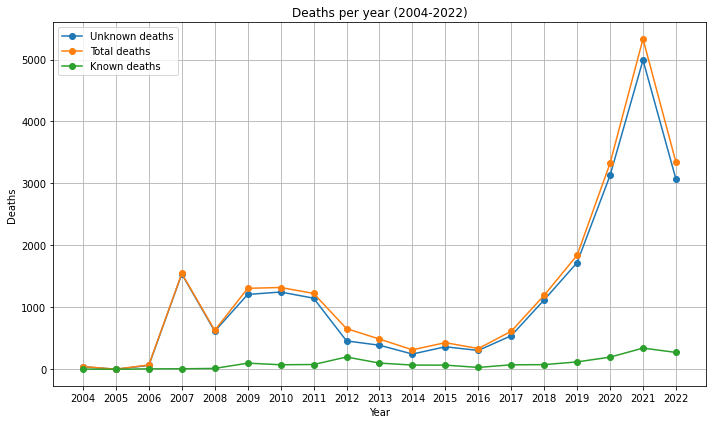

In [2]:
data = dataframe
#data = data.drop('date_end_2', axis=1)
data = data.drop('adm_1', axis=1)
data = data.drop('adm_2', axis=1)
data = data.drop('latitude', axis=1)
data = data.drop('longitude', axis=1)
data = data.drop('cart_a', axis=1)
data = data.drop('cart_b', axis=1)
data['mue_cono'] = data['mue_a']+data['mue_b']+data['mue_civ']
data = data.drop('mue_a', axis=1)
data = data.drop('mue_b', axis=1)
data = data.drop('mue_civ', axis=1)
# Extraer el año de la columna 'tiempo'
data['año'] = data['date_start_2'].dt.year
# Agrupar por año y sumar las cantidades en las columnas muertes1 a muertes5
data_agrupado_por_año = data.groupby('año').sum().reset_index()
# Mapear nombres de columnas para la leyenda
nombre_columnas = {
    'mue_cono': 'Known deaths',
    'mue_desc': 'Unknown deaths',
    'best_est': 'Total deaths'
}
# Graficar los datos
plt.figure(figsize=(10, 6))
for columna in data_agrupado_por_año.columns[1:]:
    plt.plot(data_agrupado_por_año['año'], data_agrupado_por_año[columna], marker='o', label=nombre_columnas[columna])
plt.title('Deaths per year (2004-2022)')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.legend()
plt.grid(True)
plt.xticks(data_agrupado_por_año['año'])
plt.tight_layout()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Suma de muertes por año.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
muertes_totales_escalar = dataframe['best_est'].sum()
muertes_totales_escalar

24014

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.03it/s]
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/3983663065.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['carteles'] = top_10['carteles'].str.replace('Jalisco Cartel New Generation', 'JCNG')
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/3983663065.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['carteles'] = top_10['carteles'].str.replace('Cartel', 'C.')


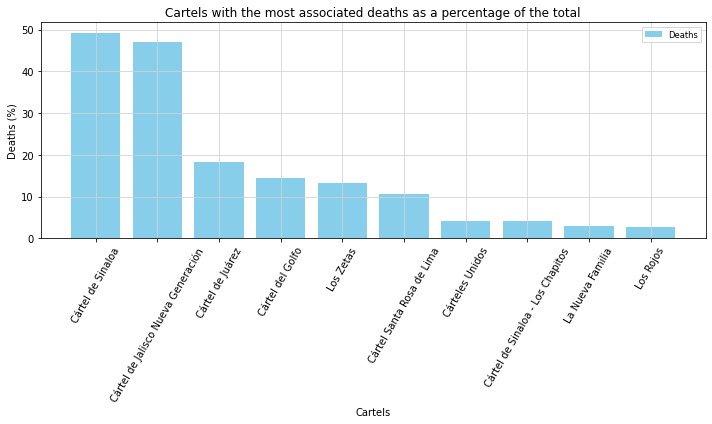

In [4]:
#Tabla cárteles con más muertos asociados / Barras

# Concatenar ambas columnas de cárteles y eliminamos los duplicados
list_cart = pd.concat([dataframe['cart_a'], dataframe['cart_b']]).drop_duplicates().reset_index(drop=True)
# Crear un nuevo DataFrame con la lista de nombres
df_list_cart = pd.DataFrame({'carteles': list_cart})
df_list_cart['muertos'] = 0

#Recorrido y suma a lo largo de cart_a
for i in tqdm(range(0, len(df_list_cart))):
    for k in range(0, len(dataframe)):
        if df_list_cart.loc[i, 'carteles'] == dataframe.loc[k, 'cart_a']:
            df_list_cart.loc[i, 'muertos'] = df_list_cart.loc[i, 'muertos'] + dataframe.loc[k, 'best_est']
#Recorrido y suma a lo largo de cart_b
for i in tqdm(range(0, len(df_list_cart))):
    for k in range(0, len(dataframe)):
        if df_list_cart.loc[i, 'carteles'] == dataframe.loc[k, 'cart_b']:
            df_list_cart.loc[i, 'muertos'] = df_list_cart.loc[i, 'muertos'] + dataframe.loc[k, 'best_est']
#############################################################################################################            
for i in range(len(df_list_cart)):
    df_list_cart.loc[i, 'muertos'] = (df_list_cart.loc[i, 'muertos']/muertes_totales_escalar)*100

#############################################################################################################
# Ordenar el DataFrame por la columna 'Calificaciones' de mayor a menor
df_list_cart = df_list_cart.sort_values(by='muertos', ascending=False)
# Restablecer el índice
df_list_cart = df_list_cart.reset_index(drop=True)
top_10 = df_list_cart.head(10)
top_10['carteles'] = top_10['carteles'].str.replace('Jalisco Cartel New Generation', 'JCNG')
top_10['carteles'] = top_10['carteles'].str.replace('Cartel', 'C.')

# Graficar la gráfica de barras de los 10 valores más altos
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura
plt.bar(top_10['carteles'], top_10['muertos'], color='skyblue')
plt.xlabel('Cartels')
plt.ylabel('Deaths (%)')
plt.title('Cartels with the most associated deaths as a percentage of the total')
plt.xticks(rotation=60)  # Rotar los nombres en el eje x para mayor legibilidad
plt.legend(['Deaths'], fontsize='small')  # Ajustar el tamaño de la letra de la leyenda
plt.tight_layout()  # Ajustar el diseño para evitar que se corten los elementos
plt.grid(True, color='lightgray')
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Carteles Histograma.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\PC\AppData\Local\Temp/ipykernel_21092/3726022066.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('\(', '')
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/3726022066.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('\)', '')


<Figure size 720x432 with 0 Axes>

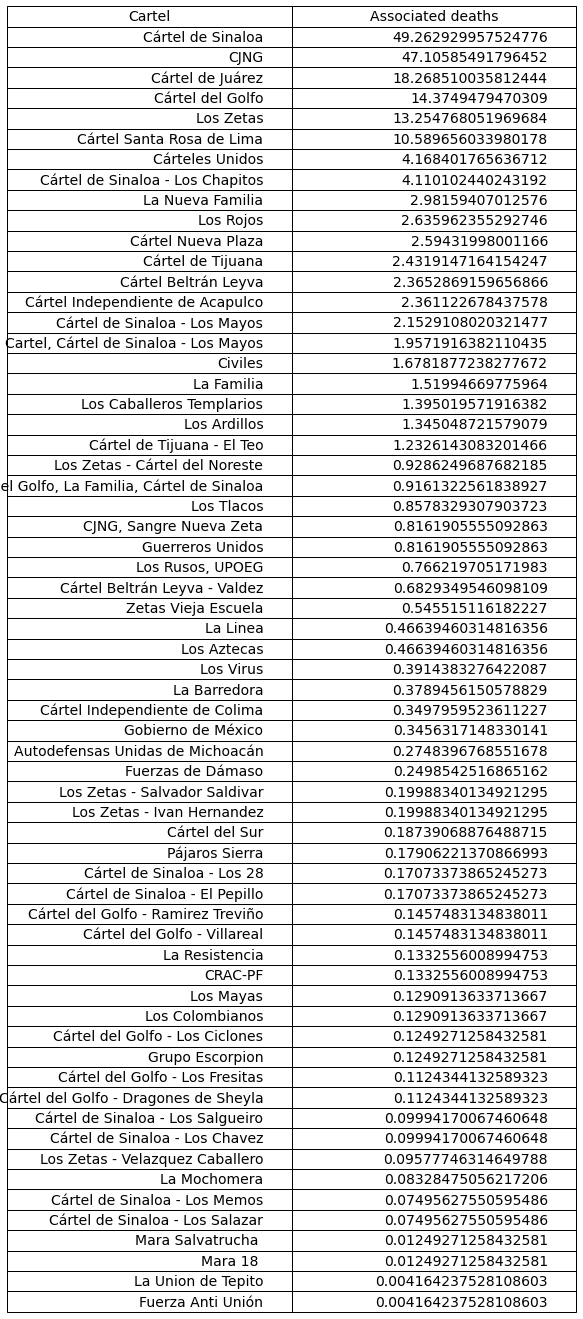

In [5]:
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('Cártel de Jalisco Nueva Generación', 'CJNG')
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('Guatemala', '')
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('\(', '')
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('\)', '')
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('Juan Pedro Salvador Saldivar Farias', 'Salvador Saldivar')
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('Jorge Ivan Hernandez Cantu', 'Ivan Hernandez')
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('Valdez Villareal', 'Valdez')
df_list_cart['carteles'] = df_list_cart['carteles'].str.replace('Los Chavez Matamoros', 'Los Chavez')
#df_list_cart = df_list_cart.drop(axis = 0, index = 46)
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 6))
# Crear una figura y un eje
fig, ax = plt.subplots()
# Ocultar ejes
ax.axis('off')
# Crear la tabla y mostrar los datos
tabla = ax.table(cellText=df_list_cart.values, colLabels=['Cartel', 'Associated deaths'], loc='center')
# Establecer estilo de la tabla
tabla.auto_set_font_size(False)
tabla.set_fontsize(14)
tabla.scale(1.7, 1.7)  # Ajustar el tamaño de la tabla
# Guardar la figura como una imagen
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Carteles Tabla.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
df_list_cart.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Tabla_muertes_asociadas.csv', index=False)

plt.show()

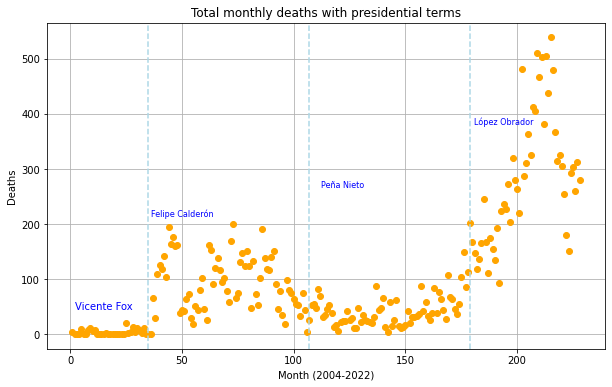

In [6]:
#Obtener una gráfica general por mes con los periodos presidenciales
año_ini = 2004
#Creamos otro dataframe para trabajar que solo guarde fecha, mes, año, muertes totales
datatot = pd.DataFrame()
datatot['Fecha'] = dataframe['date_start_2']
datatot['Total'] = dataframe['best_est']
# Crear una nueva columna 'mes' que contenga solo el mes de cada fecha
datatot['Mes'] = datatot['Fecha'].dt.month
# Crear una nueva columna 'año' que contenga solo el año de cada fecha
datatot['Año'] = datatot['Fecha'].dt.year
# Ordenar por fecha ascendente y reseteamos el índice
datatot = datatot.sort_values('Fecha')
datatot = datatot.reset_index(drop=True)
#algoritmo para contar los meses desde 2004 hasta 2019
for i in range(len(datatot)):
    if datatot.loc[i, 'Año'] != año_ini:
        datatot.loc[i, 'Mes'] = datatot.loc[i, 'Mes'] + (datatot.loc[i, 'Año'] - año_ini)*12 
#######################################
#Eliminamos columnas innecesarias
datatot = datatot.drop('Fecha', axis=1)
datatot = datatot.drop('Año', axis=1)
# Agrupar por mes y calcular la suma de las muertes. Convertimos la columna mes a entero pues es flotante
datatot = datatot.groupby('Mes')['Total'].sum().reset_index()
datatot['Mes'] = datatot['Mes'].astype(int)
# Rellenar los meses faltantes (huecos) y les asignamos cero muertos.
max_mes = datatot['Mes'].max()
todos_meses = pd.DataFrame({'Mes': range(1, max_mes + 1)})
datatot = todos_meses.merge(datatot, on='Mes', how='left').fillna(0)
# Función para asignar el nombre del presidente según el rango de meses a la base de datos.
def asignar_presidente(mes):
    if mes <= 35:
        return 'Vicente Fox'
    elif mes <= 107:
        return 'Felipe Calderón'
    elif mes <= 179:
        return 'Peña Nieto'
    elif mes <= 192:
        return 'López Obrador'
    else:
        return None
# Agregar la columna de presidentes utilizando la función
datatot['Presidente'] = datatot['Mes'].apply(asignar_presidente)
# Graficar las puntuaciones a lo largo del tiempo con los nombres de los presidentes en los periodos presidenciales
plt.figure(figsize=(10, 6))
plt.plot(datatot['Mes'], datatot['Total'], marker='o', linestyle='', color = 'orange')
# Etiquetar los periodos presidenciales en el eje x
plt.text(15, datatot.loc[15, 'Total']+40, 'Vicente Fox', ha='center', va='bottom', fontsize=10, color='Blue')
for i in range(35, 193, 72):
    plt.text(i+15, datatot.loc[i, 'Total']+210, datatot.loc[i, 'Presidente'], ha='center', va='bottom', fontsize=8, color='Blue')
    plt.axvline(x=i, color='lightblue', linestyle='--')
# Configuración del gráfico
plt.xlabel('Month (2004-2022)')
plt.ylabel('Deaths')
plt.title('Total monthly deaths with presidential terms')
plt.grid(True)
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Totales Presidentes.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

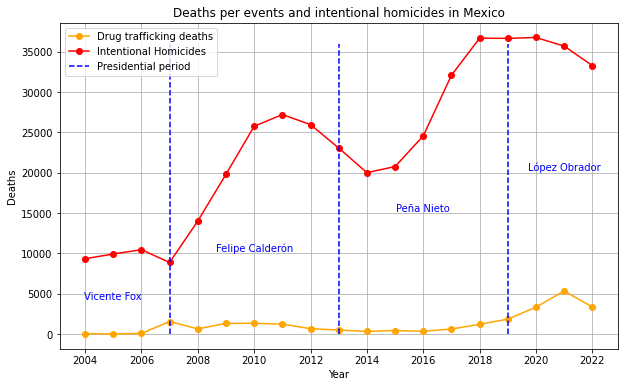

In [7]:
año_ini=2003
año_ini2=2004
defunciones = (defunciones[defunciones['Year'] >= 2004])
defunciones = defunciones.reset_index(drop=True)
defunciones['Mes'] = 0
for i in range(len(defunciones)):
    if defunciones.loc[i, 'Year'] != año_ini:
        defunciones.loc[i, 'Mes'] = defunciones.loc[i, 'Mes'] + (defunciones.loc[i, 'Year'] - año_ini)*12 
defunciones['Year'] = defunciones['Year'].astype(int)
defunciones['Deaths_log'] = np.log(defunciones['Deaths'])
#Creamos otro dataframe para trabajar que solo guarde fecha, mes, año, muertes totales
datatot2 = pd.DataFrame()
datatot2['Fecha'] = dataframe['date_start_2']
datatot2['Total'] = dataframe['best_est']
# Crear una nueva columna 'mes' que contenga solo el mes de cada fecha
datatot2['Mes'] = datatot2['Fecha'].dt.month
# Crear una nueva columna 'año' que contenga solo el año de cada fecha
datatot2['Año'] = datatot2['Fecha'].dt.year
# Ordenar por fecha ascendente y reseteamos el índice
datatot2 = datatot2.sort_values('Fecha')
datatot2 = datatot2.reset_index(drop=True)
#algoritmo para contar los meses desde 2004 hasta 2019
for i in range(len(datatot2)):
    if datatot2.loc[i, 'Año'] != año_ini2:
        datatot2.loc[i, 'Mes'] = datatot2.loc[i, 'Mes'] + (datatot2.loc[i, 'Año'] - año_ini2)*12 
#Eliminamos columnas innecesarias
datatot2 = datatot2.drop('Fecha', axis=1)
datatot2 = datatot2.drop('Mes', axis=1)
# Agrupar por mes, cartel_a y cartel_b y sumar las muertes asociadas
datatot2 = datatot2.groupby(['Año'])['Total'].sum().reset_index()
def asignar_presidente_año(año):
    if año <= 2006:
        return 'Vicente Fox'
    elif año <= 2012:
        return 'Felipe Calderón'
    elif año <= 2018:
        return 'Peña Nieto'
    elif año <= 2024:
        return 'López Obrador'
    else:
        return None
# Agregar la columna de presidentes utilizando la función
datatot2['Presidente'] = datatot2['Año'].apply(asignar_presidente_año)
datatot2['Año'] = datatot2['Año'].astype(int)

datatot2['Total_log'] = np.log(datatot2['Total'])


# Graficar las puntuaciones a lo largo del tiempo con los nombres de los presidentes en los periodos presidenciales
plt.figure(figsize=(10, 6))
#plt.plot(datatot2['Año'], datatot2['Total_log'], marker='o', linestyle='-', color = 'orange', label='Muertes Narcotráfico')
#plt.plot(defunciones['Year'], defunciones['Deaths_log'], marker='o', linestyle='-', color = 'red', label='Homicidios dolosos')
plt.plot(datatot2['Año'], datatot2['Total'], marker='o', linestyle='-', color = 'orange', label='Drug trafficking deaths')
plt.plot(defunciones['Year'], defunciones['Deaths'], marker='o', linestyle='-', color = 'red', label='Intentional Homicides')


plt.text(2005, datatot2.loc[1, 'Total']+4000, 'Vicente Fox', ha='center', va='bottom', fontsize=10, color='Blue')
plt.text(2010, datatot2.loc[1, 'Total']+10000, 'Felipe Calderón', ha='center', va='bottom', fontsize=10, color='Blue')
plt.text(2016, datatot2.loc[1, 'Total']+15000, 'Peña Nieto', ha='center', va='bottom', fontsize=10, color='Blue')
plt.text(2021, datatot2.loc[1, 'Total']+20000, 'López Obrador', ha='center', va='bottom', fontsize=10, color='Blue')
# Añadir líneas verticales punteadas en los años 2006, 2012 y 2018
plt.vlines([2007, 2013, 2019], ymin=0, ymax=36000, linestyles='dashed', colors='blue', label='Presidential period')


# Configuración del gráfico
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Deaths per events and intentional homicides in Mexico')
# Configurar los ticks del eje x para que sean enteros
plt.xticks(range(min(datatot2['Año']), max(datatot2['Año']) + 1, 2))  # Mostrar años cada 2 años

plt.legend()
plt.grid(True)
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Totales Presidentes 2.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

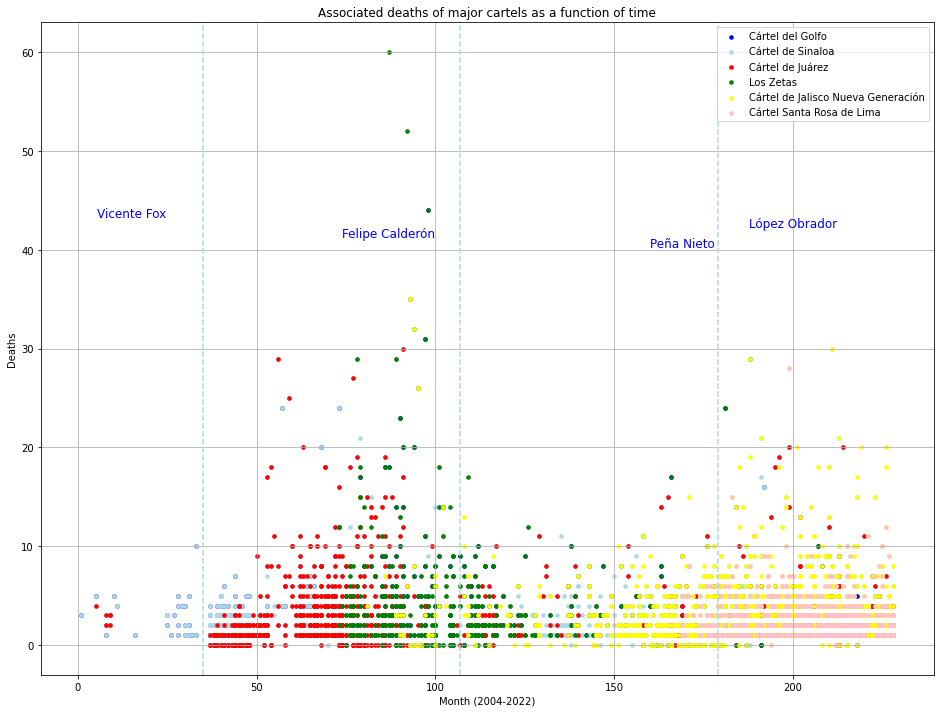

In [8]:
#Los 6 cárteles con más muertos
lista_nombres = ['Cártel de Sinaloa', 'Cártel de Jalisco Nueva Generación', 'Los Zetas', 'Cártel de Juárez', 'Cártel del Golfo', 'Cártel Santa Rosa de Lima']
#este DF contiene solo las columnas que incluyan al menos 1 de los 6 en cart_a o b
data_filtrado = dataframe[dataframe[['cart_a', 'cart_b']].isin(lista_nombres).any(axis=1)]
data_parciales = pd.DataFrame()
data_parciales['Fecha'] = data_filtrado['date_start_2']
data_parciales['cart_a'] = data_filtrado['cart_a']
data_parciales['cart_b'] = data_filtrado['cart_b']
data_parciales['Muertes'] = data_filtrado['best_est']
data_parciales = data_parciales.reset_index(drop=True)
data_filtrado = pd.DataFrame()
lista_nombres = pd.DataFrame(lista_nombres)
lista_nombres = lista_nombres.rename(columns={0: 'Cartel'})

# Juntar las dos columnas en una sola columna carteles
data_parciales_1 = pd.DataFrame(pd.concat([data_parciales['cart_a'], data_parciales['cart_b']]))
data_parciales_1 = data_parciales_1.reset_index(drop=True)
data_parciales_1 = data_parciales_1.rename(columns={0: 'Cartel'})
# Juntar las dos columnas en una sola columna fechas
data_parciales_2 = pd.DataFrame(pd.concat([data_parciales['Fecha'], data_parciales['Fecha']]))
data_parciales_2 = data_parciales_2.reset_index(drop=True)
data_parciales_2 = data_parciales_2.rename(columns={0: 'Fecha'})
# Juntar las dos columnas en una sola columna Muertes
data_parciales_3 = pd.DataFrame(pd.concat([data_parciales['Muertes'], data_parciales['Muertes']]))
data_parciales_3 = data_parciales_3.reset_index(drop=True)
data_parciales_3 = data_parciales_3.rename(columns={0: 'Muertes'})
# Concatenar los DataFrames
data_parciales_final = pd.concat([data_parciales_1, data_parciales_2, data_parciales_3], axis=1)
# Ordenar el DataFrame por la columna 'fecha'
data_parciales_final = data_parciales_final.sort_values(by='Fecha', ascending=True)
# Obtener la lista de nombres del DataFrame 2
lista = []
lista = lista_nombres['Cartel']
# Filtrar las filas del DataFrame 1 que contienen al menos uno de los nombres en la lista de nombres del DataFrame 2
data_parciales_final = data_parciales_final[data_parciales_final['Cartel'].isin(lista)]
data_parciales_final = data_parciales_final.reset_index(drop=True)

# Crear una nueva columna 'mes' que contenga solo el mes de cada fecha
data_parciales_final['Mes'] = data_parciales_final['Fecha'].dt.month
# Crear una nueva columna 'año' que contenga solo el año de cada fecha
data_parciales_final['Año'] = data_parciales_final['Fecha'].dt.year
#algoritmo para contar los meses desde 2004 hasta 2019
año_ini = 2004
for i in range(len(data_parciales_final)):
    if data_parciales_final.loc[i, 'Año'] != año_ini:
        data_parciales_final.loc[i, 'Mes'] = data_parciales_final.loc[i, 'Mes'] + (data_parciales_final.loc[i, 'Año'] - año_ini)*12
#Eliminamos columnas innecesarias
data_parciales_final = data_parciales_final.drop('Fecha', axis=1)
data_parciales_final = data_parciales_final.drop('Año', axis=1)        
# Agregar la columna de presidentes utilizando la función
data_parciales_final['Presidente'] = data_parciales_final['Mes'].apply(asignar_presidente)

# Definir colores para cada nombre
colores = {'Cártel de Sinaloa': 'lightblue', 'Cártel de Jalisco Nueva Generación': 'yellow', 'Los Zetas': 'green', 'Cártel de Juárez': 'red', 'Cártel del Golfo': 'blue', 'Cártel Santa Rosa de Lima': 'pink'}
#colores = {'Sinaloa Cartel': 'lightblue', 'Jalisco Cartel New Generation': 'lightblue', 'Los Zetas': 'lightblue', 'Juarez Cartel': 'lightblue', 'Gulf Cartel': 'red', 'Santa Rosa de Lima Cartel': 'lightblue'}

# Graficar la puntuación de cada nombre en función del tiempo
plt.figure(figsize=(16, 12))
for nombre in data_parciales_final['Cartel'].unique():
    df_temp = data_parciales_final[data_parciales_final['Cartel'] == nombre]
    plt.scatter(df_temp['Mes'], df_temp['Muertes'], label=nombre, color=colores[nombre],s=12.5)
# Etiquetar los periodos presidenciales en el eje x
plt.text(35-20, data_parciales_final.loc[35, 'Muertes']+40, data_parciales_final.loc[35, 'Presidente'], ha='center', va='bottom', fontsize=12, color='Blue')
plt.text(107-20, data_parciales_final.loc[107, 'Muertes']+40, data_parciales_final.loc[107, 'Presidente'], ha='center', va='bottom', fontsize=12, color='Blue')
plt.text(169, data_parciales_final.loc[179, 'Muertes']+40, 'Peña Nieto', ha='center', va='bottom', fontsize=12, color='Blue')
plt.text(190+10, data_parciales_final.loc[180, 'Muertes']+40, 'López Obrador', ha='center', va='bottom', fontsize=12, color='Blue')

for i in range(35, 229, 72):
    plt.axvline(x=i, color='lightblue', linestyle='--')    
    
plt.xlabel('Month (2004-2022)')
plt.ylabel('Deaths')
plt.title('Associated deaths of major cartels as a function of time')
plt.legend()
plt.grid(True)
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Parciales Presidentes.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

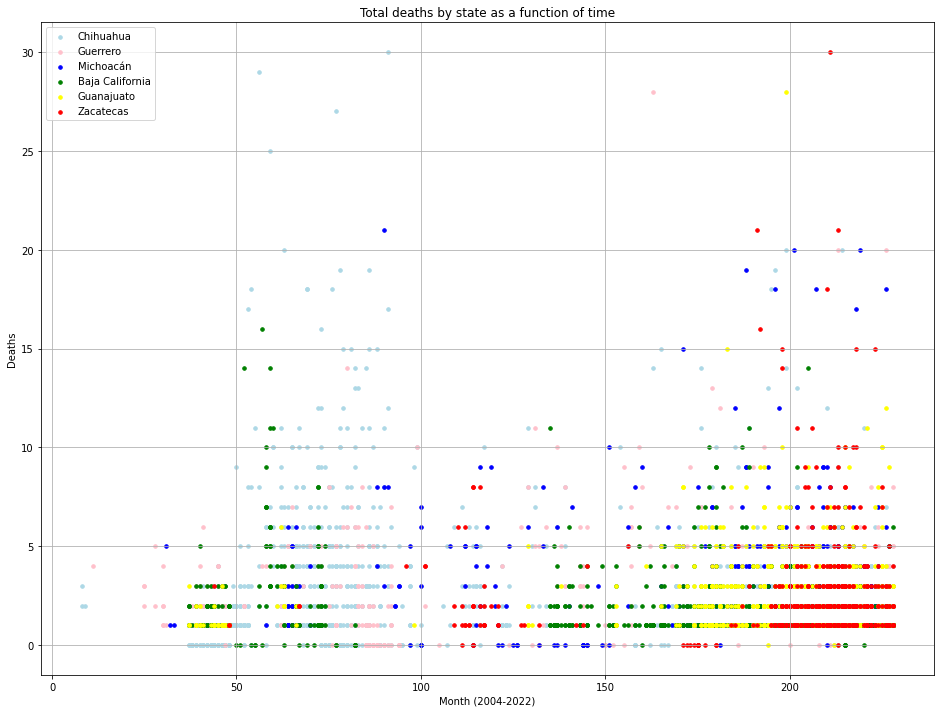

In [9]:
# Concatenar ambas columnas de cárteles y eliminamos los duplicados
list_est = dataframe['adm_1'].drop_duplicates().reset_index(drop=True)
# Crear un nuevo DataFrame con la lista de nombres
df_list_est = pd.DataFrame({'estado': list_est})
df_list_est['muertos'] = 0
#Recorrido y suma
for i in range(0, len(df_list_est)):
    for k in range(0, len(dataframe)-1):
        if df_list_est.loc[i, 'estado'] == dataframe.loc[k, 'adm_1']:
            df_list_est.loc[i, 'muertos'] = df_list_est.loc[i, 'muertos'] + dataframe.loc[k, 'best_est']
df_list_est = df_list_est.sort_values(by='muertos', ascending=False)
df_list_est = df_list_est.reset_index(drop=True)

# Obtener la lista de 6 estados. DEBE SER UNA LISTA, NO UN DATAFRAME, SI ES UN DATAFRAME NO HACE NADA LA INST. .isin()
lista = []
lista = df_list_est['estado'].head(6)
# Filtrar el primer DataFrame
data_temp = pd.DataFrame()
data_temp = dataframe[dataframe['adm_1'].isin(lista)]
#lista = []
data_estado = pd.DataFrame()
data_estado['Fecha'] = data_temp['date_start_2']
data_estado['Estado'] = data_temp['adm_1']
data_estado['Muertes'] = data_temp['best_est']

# Crear una nueva columna 'mes' que contenga solo el mes de cada fecha
data_estado['Mes'] = data_estado['Fecha'].dt.month
# Crear una nueva columna 'año' que contenga solo el año de cada fecha
data_estado['Año'] = data_estado['Fecha'].dt.year
# Ordenar el DataFrame por la columna 'fecha'
data_estado = data_estado.sort_values(by='Fecha', ascending=True)
data_estado = data_estado.reset_index(drop=True)

#algoritmo para contar los meses desde 2004 hasta 2019
año_ini = 2004
for i in range(len(data_estado)):
    if data_estado.loc[i, 'Año'] != año_ini:
        data_estado.loc[i, 'Mes'] = data_estado.loc[i, 'Mes'] + (data_estado.loc[i, 'Año'] - año_ini)*12

#Eliminamos columnas innecesarias
#data_estado = data_estado.drop('Fecha', axis=1)
#data_estado = data_estado.drop('Año', axis=1)      
#colores = {'Chihuahua state': 'lightblue', 'Nuevo León state': 'yellow', 'Baja California state': 'green', 'Tamaulipas state': 'red', 'Michoacán state': 'blue', 'Guerrero state': 'pink'}
colores = {'Chihuahua': 'lightblue', 'Guanajuato': 'yellow', 'Baja California': 'green', 'Zacatecas': 'red', 'Michoacán': 'blue', 'Guerrero': 'pink'}

df_temp=pd.DataFrame()
# Graficar la puntuación de cada nombre en función del tiempo
plt.figure(figsize=(16, 12))
for nombre in data_estado['Estado'].unique():
    df_temp = data_estado[data_estado['Estado'] == nombre]
    plt.scatter(df_temp['Mes'], df_temp['Muertes'], label=nombre, color=colores[nombre],s=12.5)
plt.xlabel('Month (2004-2022)')
plt.ylabel('Deaths')
plt.title('Total deaths by state as a function of time')
plt.legend()
plt.grid(True)
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Muertes por Estado.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()


In [10]:
#Reduccion de las bases de datos a las necesarias por nuestra base del narco
municipios = municipios.rename(columns={'Area (km^2)' : 'Area'})
municipios = municipios[municipios['Area'] != 0]
municipios = municipios.reset_index(drop=True)
poblacion = poblacion[poblacion['Year'] <= 2022]
poblacion = poblacion[poblacion['Sex'] == 'Total']
poblacion = poblacion.reset_index(drop=True)

for k in tqdm(range(0, len(municipios))):
    for i in range(0, len(poblacion)):
        if poblacion.loc[i, 'Code'] == municipios.loc[k, 'Code']:
            poblacion.loc[i, 'State'] = municipios.loc[k, 'State']  
poblacion = poblacion.dropna()
poblacion = poblacion.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [02:19<00:00,  3.03it/s]


In [11]:
#Se unen ambas bases para formar una más completa
for k in tqdm(range(0, len(municipios))):
    for i in range(0, len(poblacion)):
        if poblacion.loc[i, 'Code'] == municipios.loc[k, 'Code']:
            poblacion.loc[i, 'Municipal'] = municipios.loc[k, 'Municipal']
            poblacion.loc[i, 'Area'] = municipios.loc[k, 'Area']

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:24<00:00, 17.08it/s]


In [12]:
data_estado['Estado'] = data_estado['Estado'].str.replace(' state', '')
data_estado2 = data_estado[data_estado['Año'] >= 2010]
data_estado2 = data_estado2.reset_index(drop=True)
data_estado2 = data_estado2.drop('Mes', axis=1)

# Agrupar por año y estado, y sumar las muertes
data_estado2 = data_estado2.groupby(['Año', 'Estado'])['Muertes'].sum().reset_index()
data_estado2['Estado'] = data_estado2['Estado'].str.replace('á', 'a')
data_estado2['Estado'] = data_estado2['Estado'].str.replace('ó', 'o')

In [13]:
poblacion_raw = poblacion_raw[poblacion_raw['Year'] <= 2022]
poblacion_raw = poblacion_raw[poblacion_raw['Sex'] == 'Total']
poblacion_raw = poblacion_raw.reset_index(drop=True)

poblacion_raw_bajac_fin = pd.DataFrame()
poblacion_raw_bajac = poblacion_raw[poblacion_raw['Code'] <= 2999]
poblacion_raw_bajac = poblacion_raw_bajac[poblacion_raw_bajac['Code'] >= 2000]
for y in range(2010, 2023, 1):
    poblacion_raw_bajac_aux = poblacion_raw_bajac[poblacion_raw_bajac['Year'] == y]
    poblacion_raw_bajac_fin = poblacion_raw_bajac_fin.append(poblacion_raw_bajac_aux.groupby('Year').sum().reset_index())
poblacion_raw_bajac_fin['Code'] = 'Baja California'

poblacion_raw_chihua_fin = pd.DataFrame()
poblacion_raw_chihua = poblacion_raw[poblacion_raw['Code'] <= 8999]
poblacion_raw_chihua = poblacion_raw_chihua[poblacion_raw_chihua['Code'] >= 8000]
for y in range(2010, 2023, 1):
    poblacion_raw_chihua_aux = poblacion_raw_chihua[poblacion_raw_chihua['Year'] == y]
    poblacion_raw_chihua_fin = poblacion_raw_chihua_fin.append(poblacion_raw_chihua_aux.groupby('Year').sum().reset_index())
poblacion_raw_chihua_fin['Code'] = 'Chihuahua'

poblacion_raw_nuevo_fin = pd.DataFrame()
poblacion_raw_nuevo = poblacion_raw[poblacion_raw['Code'] <= 11999]
poblacion_raw_nuevo = poblacion_raw_nuevo[poblacion_raw_nuevo['Code'] >= 11000]
for y in range(2010, 2023, 1):
    poblacion_raw_nuevo_aux = poblacion_raw_nuevo[poblacion_raw_nuevo['Year'] == y]
    poblacion_raw_nuevo_fin = poblacion_raw_nuevo_fin.append(poblacion_raw_nuevo_aux.groupby('Year').sum().reset_index())
poblacion_raw_nuevo_fin['Code'] = 'Guanajuato'

poblacion_raw_guerre_fin = pd.DataFrame()
poblacion_raw_guerre = poblacion_raw[poblacion_raw['Code'] <= 12999]
poblacion_raw_guerre = poblacion_raw_guerre[poblacion_raw_guerre['Code'] >= 12000]
for y in range(2010, 2023, 1):
    poblacion_raw_guerre_aux = poblacion_raw_guerre[poblacion_raw_guerre['Year'] == y]
    poblacion_raw_guerre_fin = poblacion_raw_guerre_fin.append(poblacion_raw_guerre_aux.groupby('Year').sum().reset_index())
poblacion_raw_guerre_fin['Code'] = 'Guerrero'

poblacion_raw_michoa_fin = pd.DataFrame()
poblacion_raw_michoa = poblacion_raw[poblacion_raw['Code'] <= 16999]
poblacion_raw_michoa = poblacion_raw_michoa[poblacion_raw_michoa['Code'] >= 16000]
for y in range(2010, 2023, 1):
    poblacion_raw_michoa_aux = poblacion_raw_michoa[poblacion_raw_michoa['Year'] == y]
    poblacion_raw_michoa_fin = poblacion_raw_michoa_fin.append(poblacion_raw_michoa_aux.groupby('Year').sum().reset_index())
poblacion_raw_michoa_fin['Code'] = 'Michoacan'

poblacion_raw_tama_fin = pd.DataFrame()
poblacion_raw_tama = poblacion_raw[poblacion_raw['Code'] <= 32999]
poblacion_raw_tama = poblacion_raw_tama[poblacion_raw_tama['Code'] >= 32000]
for y in range(2010, 2023, 1):
    poblacion_raw_tama_aux = poblacion_raw_tama[poblacion_raw_tama['Year'] == y]
    poblacion_raw_tama_fin = poblacion_raw_tama_fin.append(poblacion_raw_tama_aux.groupby('Year').sum().reset_index())
poblacion_raw_tama_fin['Code'] = 'Zacatecas'

df_concatenado = pd.concat([poblacion_raw_bajac_fin, poblacion_raw_chihua_fin, poblacion_raw_guerre_fin, poblacion_raw_michoa_fin, poblacion_raw_nuevo_fin, poblacion_raw_tama_fin], ignore_index=True)
#df_concatenado['Capita'] = 

C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_bajac_fin = poblacion_raw_bajac_fin.append(poblacion_raw_bajac_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_bajac_fin = poblacion_raw_bajac_fin.append(poblacion_raw_bajac_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_bajac_fin = poblacion_raw_bajac_fin.append(poblacion_raw_bajac_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/43

C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_nuevo_fin = poblacion_raw_nuevo_fin.append(poblacion_raw_nuevo_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_guerre_fin = poblacion_raw_guerre_fin.append(poblacion_raw_guerre_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_guerre_fin = poblacion_raw_guerre_fin.append(poblacion_raw_guerre_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21

C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_tama_fin = poblacion_raw_tama_fin.append(poblacion_raw_tama_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_tama_fin = poblacion_raw_tama_fin.append(poblacion_raw_tama_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  poblacion_raw_tama_fin = poblacion_raw_tama_fin.append(poblacion_raw_tama_aux.groupby('Year').sum().reset_index())
C:\Users\PC\AppData\Local\Temp/ipykernel_21092/435910525.p

In [14]:
for k in tqdm(range(0, len(data_estado2))):
    for i in range(0, len(df_concatenado)):
        if data_estado2.loc[k, 'Estado'] == df_concatenado.loc[i, 'Code'] and data_estado2.loc[k, 'Año'] == df_concatenado.loc[i, 'Year']: 
            data_estado2.loc[k, 'Población'] = df_concatenado.loc[i, 'Population']
data_estado2['Per Capita'] = ((data_estado2['Muertes'])/(data_estado2['Población']))*(1)
data_estado2['Capita (100,000)'] = ((data_estado2['Muertes'])/(data_estado2['Población']))*(100000)


100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 1016.72it/s]


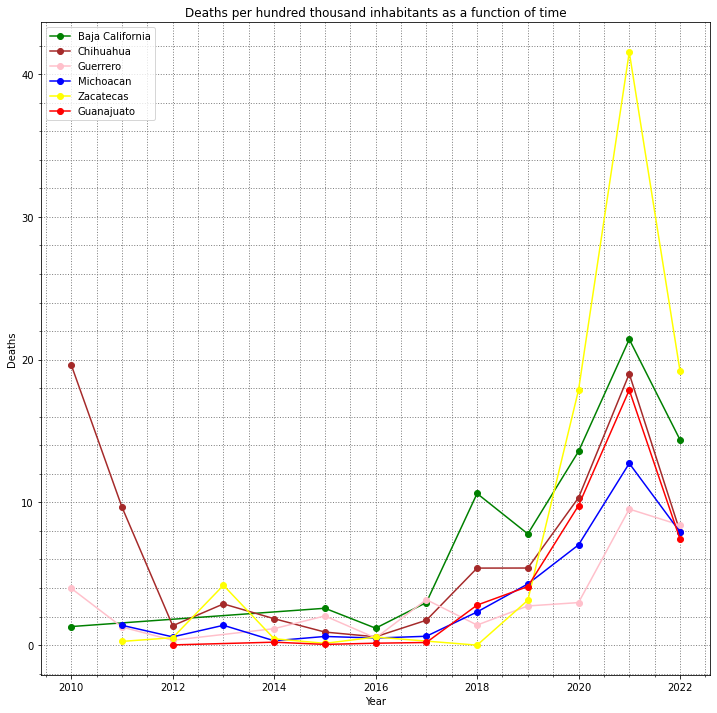

In [15]:
colores = {'Chihuahua': 'brown', 'Zacatecas': 'yellow', 'Baja California': 'green', 'Guanajuato': 'red', 'Michoacan': 'blue', 'Guerrero': 'pink'}
df_temp=pd.DataFrame()
# Graficar la puntuación de cada nombre en función del tiempo
plt.figure(figsize=(12, 12))
for nombre in data_estado2['Estado'].unique():
    df_temp = data_estado2[data_estado2['Estado'] == nombre]
    plt.plot(df_temp['Año'], df_temp['Capita (100,000)'], label=nombre, color=colores[nombre], marker='o')
#    plt.scatter(df_temp['Año'], df_temp['Capita (1,000,000)'], label=nombre, color=colores[nombre],s=50)
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Deaths per hundred thousand inhabitants as a function of time')
plt.legend()
#plt.grid(True)
# Habilitar más marcas menores en los ejes
plt.minorticks_on()  # Habilitar las marcas menores del grid
plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Muertes capita por Estado.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

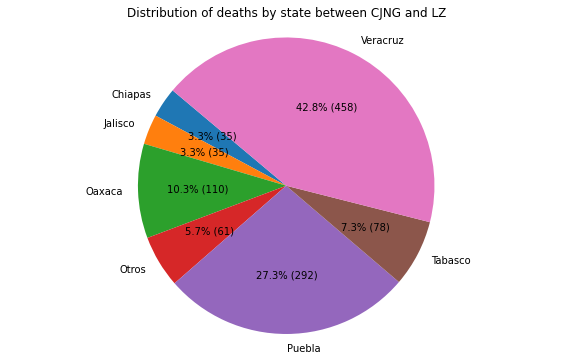

In [16]:
# Filtrar el DataFrame para conservar solo las filas que contienen 'Cártel Jalisco' o 'Los Zetas' en alguna de las dos columnas
filtro_pastel = dataframe.apply(lambda row: 'Cártel de Jalisco Nueva Generación' in [row['cart_a'], row['cart_b']] and 'Los Zetas' in [row['cart_a'], row['cart_b']], axis=1)
df_filtrado_pastel = dataframe[filtro_pastel]
df_filtrado_pastel = df_filtrado_pastel.reset_index(drop=True)
#Para hacer el gráfico de pastel:
# Agrupar por estado y sumar las muertes
df_filtrado_pastel_agrupado = df_filtrado_pastel.groupby('adm_1')['best_est'].sum().reset_index()
# Calcular el porcentaje de muertes para cada estado
df_filtrado_pastel_agrupado['porcentaje'] = (df_filtrado_pastel_agrupado['best_est'] / df_filtrado_pastel_agrupado['best_est'].sum()) * 100
# Identificar los estados que participan menos del 1% de las muertes
df_filtrado_pastel_agrupado_menor1 = df_filtrado_pastel_agrupado[df_filtrado_pastel_agrupado['porcentaje'] < 3]['adm_1'].tolist()
# Agrupar los estados con menos del 1% de muertes en una categoría 'Otros'
df_filtrado_pastel_agrupado.loc[df_filtrado_pastel_agrupado['adm_1'].isin(df_filtrado_pastel_agrupado_menor1), 'adm_1'] = 'Otros'
df_filtrado_pastel_agrupado = df_filtrado_pastel_agrupado.groupby('adm_1').sum().reset_index()


# Crear la gráfica de pastel
plt.figure(figsize=(10, 6))
plt.pie(df_filtrado_pastel_agrupado['best_est'], labels=df_filtrado_pastel_agrupado['adm_1'], autopct=lambda p: '{:.1f}% ({:,.0f})'.format(p, p * sum(df_filtrado_pastel_agrupado['best_est']) / 100), startangle=140)
#plt.pie(df_filtrado_pastel_agrupado['best_est'], labels=df_filtrado_pastel_agrupado['adm_1'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of deaths by state between CJNG and LZ')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\02 - Total de incidentes.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

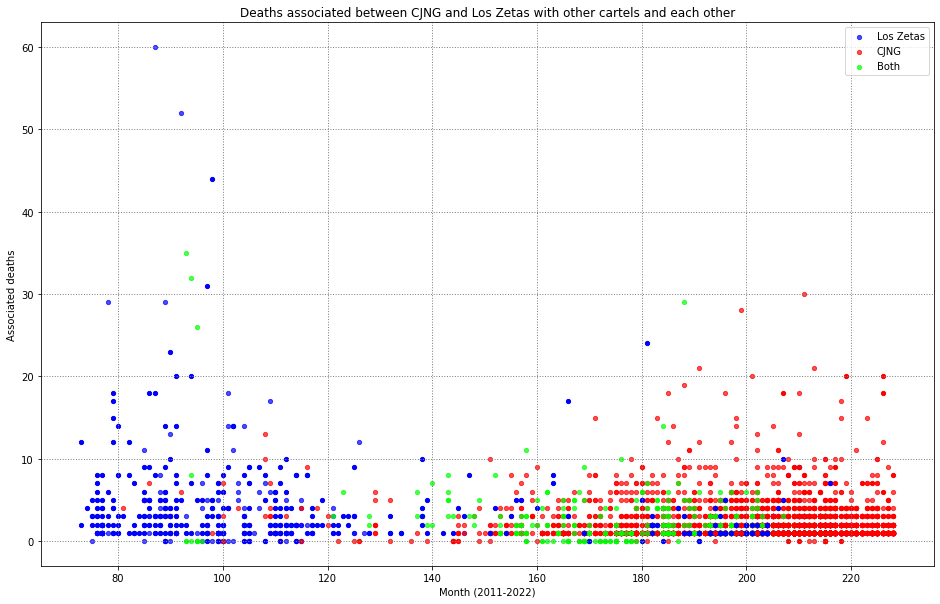

In [17]:
filtro_scatter = dataframe.apply(lambda row: 'Cártel de Jalisco Nueva Generación' in [row['cart_a'], row['cart_b']] or 'Los Zetas' in [row['cart_a'], row['cart_b']], axis=1)
df_filtrado_scatter = dataframe[filtro_scatter]
df_filtrado_scatter = df_filtrado_scatter.reset_index(drop=True)
# Crear una nueva columna 'mes' que contenga solo el mes de cada fecha
df_filtrado_scatter['Mes'] = df_filtrado_scatter['date'].dt.month
## Crear una nueva columna 'año' que contenga solo el año de cada fecha
df_filtrado_scatter['Año'] = df_filtrado_scatter['date'].dt.year
año_ini = 2004
for i in range(len(df_filtrado_scatter)):
    if df_filtrado_scatter.loc[i, 'Año'] != año_ini:
        df_filtrado_scatter.loc[i, 'Mes'] = df_filtrado_scatter.loc[i, 'Mes'] + (df_filtrado_scatter.loc[i, 'Año'] - año_ini)*12
        
        
# Filtrar filas según las condiciones requeridas
filtro_azul = (df_filtrado_scatter['cart_a'] == 'Los Zetas') & (df_filtrado_scatter['cart_b'] != 'Cártel de Jalisco Nueva Generación')
filtro_azul2 = (df_filtrado_scatter['cart_b'] == 'Los Zetas') & (df_filtrado_scatter['cart_a'] != 'Cártel de Jalisco Nueva Generación')
filtro_rojo = (df_filtrado_scatter['cart_a'] == 'Cártel de Jalisco Nueva Generación') & (df_filtrado_scatter['cart_b'] != 'Los Zetas')
filtro_rojo2 = (df_filtrado_scatter['cart_b'] == 'Cártel de Jalisco Nueva Generación') & (df_filtrado_scatter['cart_a'] != 'Los Zetas')
filtro_purpura = (df_filtrado_scatter['cart_a'] == 'Cártel de Jalisco Nueva Generación') & (df_filtrado_scatter['cart_b'] == 'Los Zetas')
filtro_purpura2 = (df_filtrado_scatter['cart_b'] == 'Cártel de Jalisco Nueva Generación') & (df_filtrado_scatter['cart_a'] == 'Los Zetas')

# Asignar colores a cada fila según las condiciones
df_filtrado_scatter.loc[filtro_azul, 'Color'] = 'blue'
df_filtrado_scatter.loc[filtro_azul2, 'Color'] = 'blue'
df_filtrado_scatter.loc[filtro_rojo, 'Color'] = 'red'
df_filtrado_scatter.loc[filtro_rojo2, 'Color'] = 'red'
df_filtrado_scatter.loc[filtro_purpura, 'Color'] = 'yellow'
df_filtrado_scatter.loc[filtro_purpura2, 'Color'] = 'yelow'
# Graficar el scatter plot
plt.figure(figsize=(16, 10))
#plt.scatter(df_filtrado_scatter['Mes'], df_filtrado_scatter['best_est'], c=df_filtrado_scatter['Color'], s=12)
# Graficar el scatter plot por cada categoría de color
plt.scatter(df_filtrado_scatter[filtro_azul]['Mes'], df_filtrado_scatter[filtro_azul]['best_est'], c='blue', label='Los Zetas', alpha=0.7, s=18)
plt.scatter(df_filtrado_scatter[filtro_rojo]['Mes'], df_filtrado_scatter[filtro_rojo]['best_est'], c='red', label='CJNG', alpha=0.7, s=18)
plt.scatter(df_filtrado_scatter[filtro_purpura]['Mes'], df_filtrado_scatter[filtro_purpura]['best_est'], c='#00FF00', label='Both', alpha=0.7, s=18)
plt.scatter(df_filtrado_scatter[filtro_azul2]['Mes'], df_filtrado_scatter[filtro_azul2]['best_est'], c='blue', s=18)
plt.scatter(df_filtrado_scatter[filtro_rojo2]['Mes'], df_filtrado_scatter[filtro_rojo2]['best_est'], c='red', s=18)
plt.scatter(df_filtrado_scatter[filtro_purpura2]['Mes'], df_filtrado_scatter[filtro_purpura2]['best_est'], c='#00FF00', s=18)

plt.xlabel('Month (2011-2022)')
plt.ylabel('Associated deaths')
plt.title('Deaths associated between CJNG and Los Zetas with other cartels and each other')
plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor
plt.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\00 CJNG - LZ Inversion(SIN SUMAR).png', dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [18]:
df_filtrado_scatter2 = pd.DataFrame()
df_filtrado_scatter2['date']=df_filtrado_scatter['date']
df_filtrado_scatter2['Mes']=df_filtrado_scatter['Mes']
df_filtrado_scatter2['cart_a']=df_filtrado_scatter['cart_a']
df_filtrado_scatter2['cart_b']=df_filtrado_scatter['cart_b']
df_filtrado_scatter2['best_est']=df_filtrado_scatter['best_est']
df_filtrado_scatter2['Color']=df_filtrado_scatter['Color']
df_aux_scatter=pd.DataFrame()

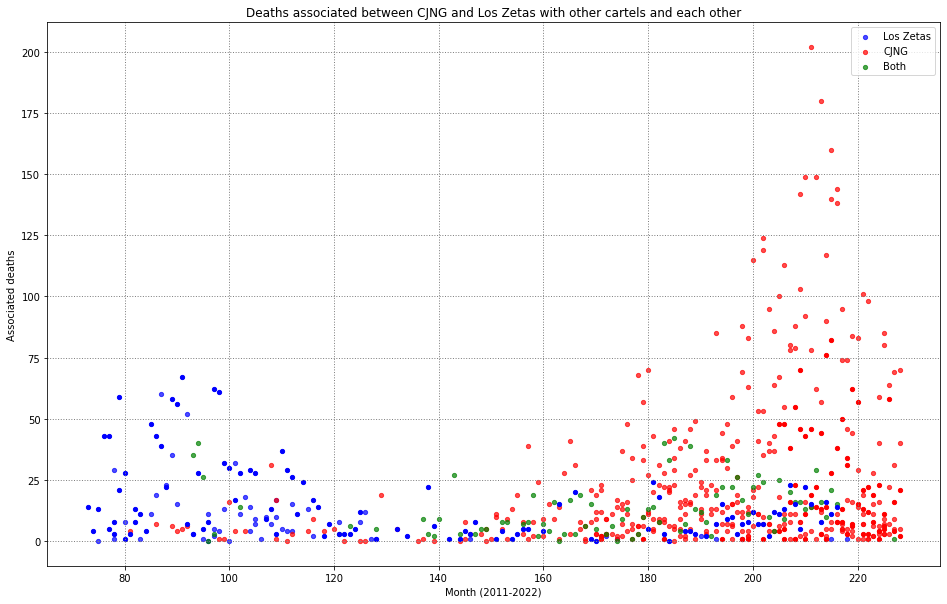

In [19]:
#####ESTA GRAFICA SERÁ IGUAL QUE LA ANTERIOR, SIN EMBARGO REDUJIMOS LAS DIMENSIONES DE 7143 A 658 FILAS SUMANDO TODAS LAS
#####FILAS QUE TENGAN EL MISMO MES, MISMO CARTEL A Y CARTEL B.

# Agrupar por mes, cartel_a y cartel_b y sumar las muertes asociadas
df_aux_scatter = df_filtrado_scatter2.groupby(['Mes', 'cart_a', 'cart_b'])['best_est'].sum().reset_index()
# Filtrar filas según las condiciones requeridas
filtro_azul = (df_aux_scatter['cart_a'] == 'Los Zetas') & (df_aux_scatter['cart_b'] != 'Cártel de Jalisco Nueva Generación')
filtro_azul2 = (df_aux_scatter['cart_b'] == 'Los Zetas') & (df_aux_scatter['cart_a'] != 'Cártel de Jalisco Nueva Generación')
filtro_rojo = (df_aux_scatter['cart_a'] == 'Cártel de Jalisco Nueva Generación') & (df_aux_scatter['cart_b'] != 'Los Zetas')
filtro_rojo2 = (df_aux_scatter['cart_b'] == 'Cártel de Jalisco Nueva Generación') & (df_aux_scatter['cart_a'] != 'Los Zetas')
filtro_purpura = (df_aux_scatter['cart_a'] == 'Cártel de Jalisco Nueva Generación') & (df_aux_scatter['cart_b'] == 'Los Zetas')
filtro_purpura2 = (df_aux_scatter['cart_b'] == 'Cártel de Jalisco Nueva Generación') & (df_aux_scatter['cart_a'] == 'Los Zetas')
# Asignar colores a cada fila según las condiciones
df_aux_scatter.loc[filtro_azul, 'Color'] = 'blue'
df_aux_scatter.loc[filtro_azul2, 'Color'] = 'blue'
df_aux_scatter.loc[filtro_rojo, 'Color'] = 'red'
df_aux_scatter.loc[filtro_rojo2, 'Color'] = 'red'
df_aux_scatter.loc[filtro_purpura, 'Color'] = 'yellow'
df_aux_scatter.loc[filtro_purpura2, 'Color'] = 'yelow'



# Graficar el scatter plot
plt.figure(figsize=(16, 10))
#plt.scatter(df_filtrado_scatter['Mes'], df_filtrado_scatter['best_est'], c=df_filtrado_scatter['Color'], s=12)
# Graficar el scatter plot por cada categoría de color
plt.scatter(df_aux_scatter[filtro_azul]['Mes'], df_aux_scatter[filtro_azul]['best_est'], c='blue', label='Los Zetas', alpha=0.7, s=18)
plt.scatter(df_aux_scatter[filtro_rojo]['Mes'], df_aux_scatter[filtro_rojo]['best_est'], c='red', label='CJNG', alpha=0.7, s=18)
plt.scatter(df_aux_scatter[filtro_purpura]['Mes'], df_aux_scatter[filtro_purpura]['best_est'], c='green', label='Both', alpha=0.7, s=18)
plt.scatter(df_aux_scatter[filtro_azul2]['Mes'], df_aux_scatter[filtro_azul2]['best_est'], c='blue', s=18)
plt.scatter(df_aux_scatter[filtro_rojo2]['Mes'], df_aux_scatter[filtro_rojo2]['best_est'], c='red', s=18)
plt.scatter(df_aux_scatter[filtro_purpura2]['Mes'], df_aux_scatter[filtro_purpura2]['best_est'], c='green', s=18)

plt.xlabel('Month (2011-2022)')
plt.ylabel('Associated deaths')
plt.title('Deaths associated between CJNG and Los Zetas with other cartels and each other')
plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor
plt.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\00 CJNG - LZ Inversion.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

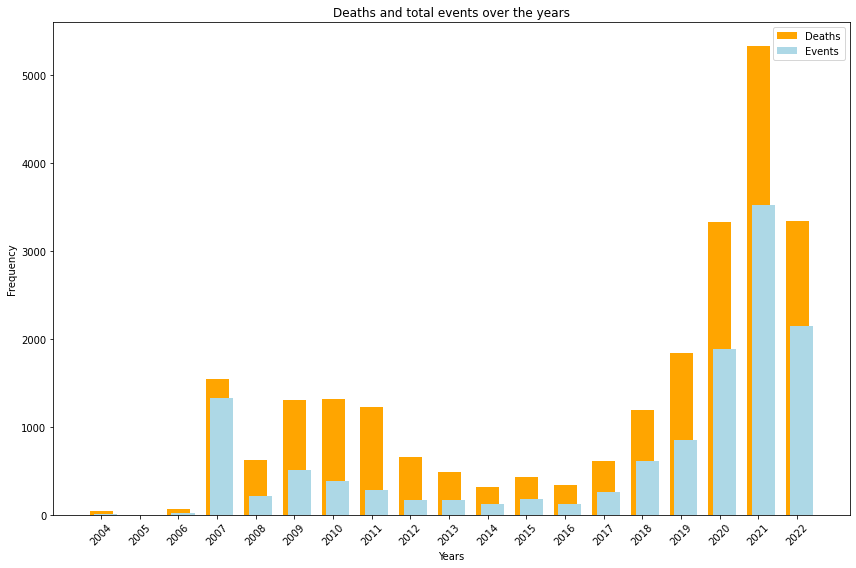

In [20]:
#GRAFICA DE BARRAS EVENTROS VS MUERTES
#Generamos un DF espejo del DF original para trabajar
dataframe_barras = dataframe
#Agregamos a cada evento un valor '1', así podemos sumar eventos y tratarlos numericamente como las muertes,  
dataframe_barras['evento'] = 1
## Crear una nueva columna 'año' que contenga solo el año de cada fecha
dataframe_barras['Año'] = dataframe_barras['date'].dt.year
#Se crean dos splits para muertes y eventos, despues los voy a concatenar
df_barras_mue = dataframe_barras.groupby(['Año'])['best_est'].sum().reset_index()
df_barras_ev= dataframe_barras.groupby(['Año'])['evento'].sum().reset_index()
# Concatenar los dos DataFrames a lo largo de las columnas
df_barras_mue_ev = pd.concat([df_barras_mue, df_barras_ev], axis=1)
# Eliminar solo una de las columnas duplicadas de Año
df_barras_mue_ev = df_barras_mue_ev.loc[:,~df_barras_mue_ev.columns.duplicated()]

bar_width = 0.6  #ncho de la barra
bar_overlap = 0.12 #Superposición de barras = 0

# Crear la gráfica de barras
plt.figure(figsize=(12, 8))
# Gráfico de barras para las muertes
plt.bar(df_barras_mue_ev['Año'], df_barras_mue_ev['best_est'], color='orange', width=bar_width, label='Deaths')
# Gráfico de barras para los eventos
plt.bar(df_barras_mue_ev['Año']+bar_overlap, df_barras_mue_ev['evento'], color='lightblue', width=bar_width, label='Events')

# Añadir etiquetas y título
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.title('Deaths and total events over the years')
plt.legend()

# Mostrar la gráfica
plt.xticks(df_barras_mue_ev['Año'], rotation=45)  # Rotar las etiquetas del eje x para mejorar la legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar cortar etiquetas
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\barras_mue_ev.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

In [21]:
########################################################################################################################
#####ESTA PARTE DEL SCRIPT ES PARA USARSE EN CONJUNTO CON Artículo.R ESTE CÓDIGO PREPARA LA BASE DE DATOS PARA EL MAPA
###POR ESTADOS DE LOS EVENTOS TOTALES EN MÉXICO
#Generamos un DF espejo del DF original para trabajar
dataframe_mex_ev_aux = pd.DataFrame()
dataframe_mex_ev_aux['Estado'] = dataframe['adm_1']
dataframe_mex_ev_aux['Eventos']= dataframe['evento']
dataframe_mex_ev_aux['Estado'] = dataframe_mex_ev_aux['Estado'].str.replace(' state', '')
dataframe_mex_ev = dataframe_mex_ev_aux.groupby(['Estado'])['Eventos'].sum().reset_index()
# Guardar el DataFrame como un archivo CSV en la ruta especificada
dataframe_mex_ev.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\dataframe_mex_ev.csv', index=False)
####finalizado con éxito
########################################################################################################################

C:\Users\PC\AppData\Local\Temp/ipykernel_21092/2185835419.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dataframe_tabla = dataframe_tabla_aux.groupby(['Estado'])['Muertos', 'Eventos'].sum().reset_index()


<Figure size 720x432 with 0 Axes>

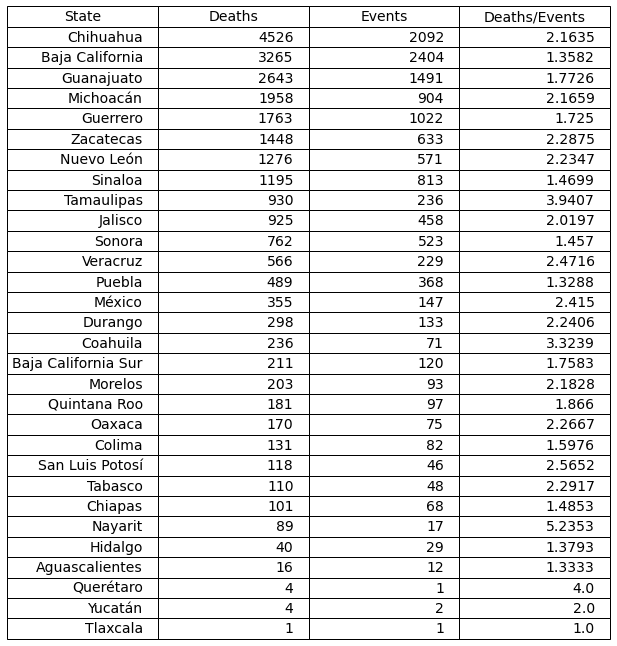

In [22]:
#####Vamos a graficar una tabla con estados, muertes, eventos, indice
dataframe_tabla_aux = pd.DataFrame()
dataframe_tabla_aux['Estado'] = dataframe['adm_1']
dataframe_tabla_aux['Eventos']= dataframe['evento']
dataframe_tabla_aux['Muertos']= dataframe['best_est']
dataframe_tabla_aux['Estado'] = dataframe_tabla_aux['Estado'].str.replace(' state', '')
#esta instruccion va a sumar los muertos y eventos para cada estado
dataframe_tabla = dataframe_tabla_aux.groupby(['Estado'])['Muertos', 'Eventos'].sum().reset_index()
#calculamos el índice
dataframe_tabla['Muertos/Evento']= dataframe_tabla['Muertos']/dataframe_tabla['Eventos']
dataframe_tabla['Muertos/Evento'] = dataframe_tabla['Muertos/Evento'].apply(lambda x: np.round(x, 4))
#Ordenamos de el DF de mayor a menor por muertos
dataframe_tabla = dataframe_tabla.sort_values(by='Muertos', ascending=False)
# Restablecer el índice
dataframe_tabla = dataframe_tabla.reset_index(drop=True)


# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 6))
# Crear una figura y un eje
fig, ax = plt.subplots()
# Ocultar ejes
ax.axis('off')
# Crear la tabla y mostrar los datos
tabla = ax.table(cellText=dataframe_tabla.values, colLabels=['State', 'Deaths', 'Events', 'Deaths/Events'], loc='center')
# Establecer estilo de la tabla
tabla.auto_set_font_size(False)
tabla.set_fontsize(14)
tabla.scale(1.8, 1.7)  # Ajustar el tamaño de la tabla
# Guardar la figura como una imagen
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Estados Tabla.png', dpi= 300,  bbox_inches='tight', pad_inches=0.05)
dataframe_tabla.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Tabla_muertes_eventos_estado.csv', index=False)

plt.show()

In [23]:
########################################################################################################################
#####ESTA PARTE DEL SCRIPT ES PARA USARSE EN CONJUNTO CON Artículo.R (SEGUNDA SCRIPT) ESTE CÓDIGO PREPARA LA BASE DE 
###DATOS PARA EL MAPA POR MUNICIPIOS DE LOS EVENTOS TOTALES EN MÉXICO USANDO DISCOS NO COLORES.
#### Mapa de México con eventos por municipio
#Creamos dos splits, el primero con municipios y coordenadas
mapa_municipios_coord = dataframe[['adm_2', 'latitude', 'longitude']].drop_duplicates(subset=['adm_2'])
mapa_municipios_coord = mapa_municipios_coord.sort_values(by='adm_2', ascending=True)
mapa_municipios_coord = mapa_municipios_coord.reset_index(drop=True)
#esta instruccion es jesucristo de nuevo
mapa_municipios_suma = dataframe.groupby(['adm_2'])['best_est', 'evento'].sum().reset_index()
mapa_municipios_suma = mapa_municipios_suma.sort_values(by='adm_2', ascending=True)
mapa_municipios_suma = mapa_municipios_suma.reset_index(drop=True)
# Concatenar los dos DataFrames a lo largo de las columnas
mapa_municipios_tot = pd.concat([mapa_municipios_coord, mapa_municipios_suma], axis=1)
# Eliminar solo una de las columnas duplicadas de Año
mapa_municipios_tot = mapa_municipios_tot.loc[:,~mapa_municipios_tot.columns.duplicated()]
mapa_municipios_tot['indice'] = mapa_municipios_tot['best_est']/mapa_municipios_tot['evento']
mapa_municipios_tot.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\mapa_municipios_tot.csv', index=False)
####finalizado con éxito
########################################################################################################################

C:\Users\PC\AppData\Local\Temp/ipykernel_21092/143465745.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mapa_municipios_suma = dataframe.groupby(['adm_2'])['best_est', 'evento'].sum().reset_index()


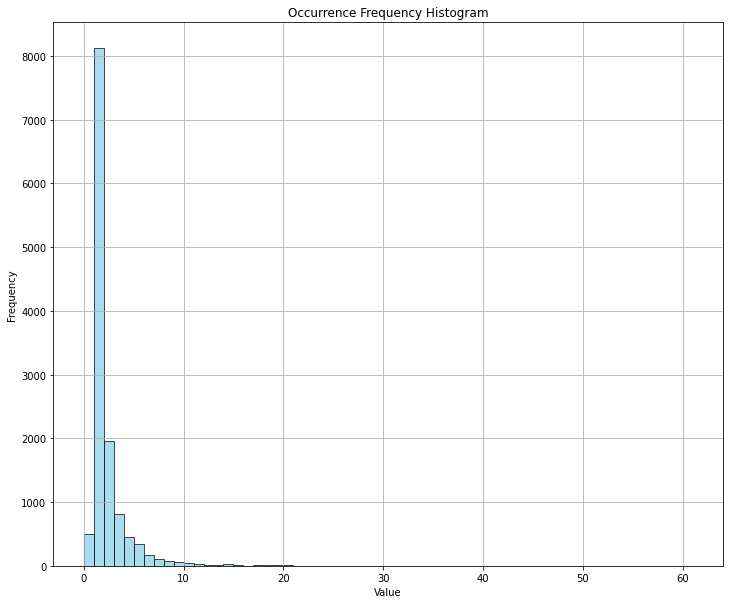

In [24]:
# Crear una lista de bordes de bins que contenga cada número único en 'best_est'
bins = sorted(dataframe['best_est'].unique()) + [dataframe['best_est'].max() + 1]  # Agregar un borde adicional para el último bin

# Graficar el histograma
plt.figure(figsize=(12, 10))
#plt.hist(dataframe['best_est'], bins=2*len(set(dataframe['best_est'])), color='skyblue', edgecolor='black', alpha=0.7)
plt.hist(dataframe['best_est'], bins=bins, density=False, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Occurrence Frequency Histogram')#Density = False PARA NO NORMALIZAR EL HISTOGRAMA y True para normalizar
plt.xlabel('Value')
plt.ylabel('Frequency')
#plt.xticks(bins) 
plt.grid(True)
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Histo frec apari.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

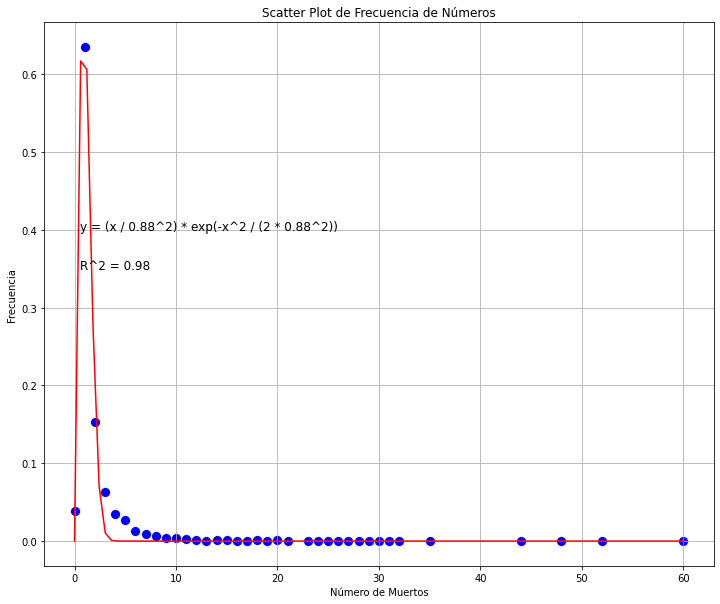

In [25]:
split_raw = pd.DataFrame()
split_raw['Muertos'] = dataframe['best_est']
# Calcular la frecuencia de cada número
split = split_raw['Muertos'].value_counts().reset_index()
split.columns = ['Muertos', 'frecuencia']
# Normalizar la frecuencia
suma_total = split['frecuencia'].sum()
split['frecuencia_normalizada'] = split['frecuencia'] / suma_total
# Definir la función de densidad de probabilidad (PDF) de la distribución de Rayleigh
def rayleigh_pdf(x, sigma):
    return (x / sigma**2) * np.exp(-x**2 / (2 * sigma**2))
# Ajustar la distribución de Rayleigh a los datos normalizados
popt, pcov = curve_fit(rayleigh_pdf, split['Muertos'], split['frecuencia_normalizada'])
# Calcular el valor R^2
y_pred = rayleigh_pdf(split['Muertos'], *popt)
r_squared = r2_score(split['frecuencia_normalizada'], y_pred)
# Graficar scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=split, x='Muertos', y='frecuencia_normalizada', s=100, color='blue')
# Graficar la distribución de Rayleigh ajustada
x_values = np.linspace(0, split['Muertos'].max(), 100)
y_values = rayleigh_pdf(x_values, *popt)
plt.plot(x_values, y_values, color='red', label='Distribución de Rayleigh Ajustada')
# Agregar la ecuación de la distribución y el valor R^2 al gráfico
plt.text(0.5, 0.4, f'y = (x / {popt[0]:.2f}^2) * exp(-x^2 / (2 * {popt[0]:.2f}^2))', fontsize=12)
plt.text(0.5, 0.35, f'R^2 = {r_squared:.2f}', fontsize=12)
plt.title('Scatter Plot de Frecuencia de Números')
plt.xlabel('Número de Muertos')
plt.ylabel('Frecuencia')
plt.grid(True)
#plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Scatter ajuste.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

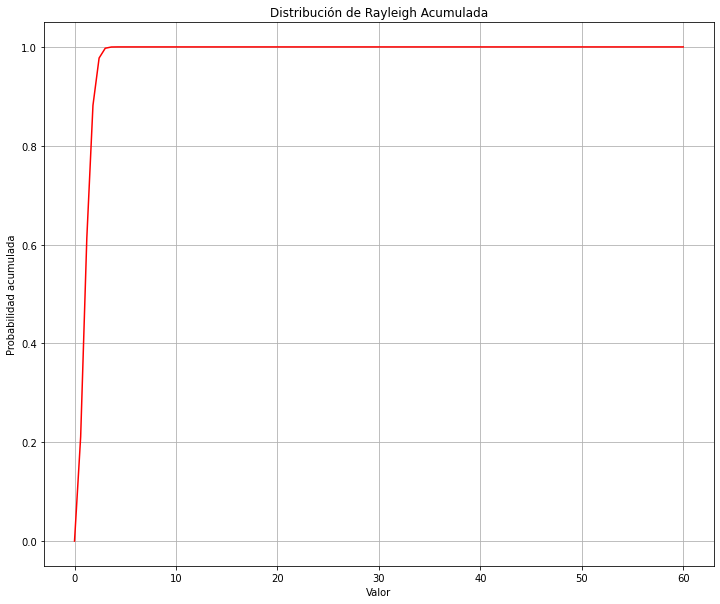

In [26]:
#Definir sigma obtenido del ajuste
sigma = 0.88

# Definir el rango de valores para la CDF
x_values = np.linspace(0, 60, 100)  # Puedes ajustar el rango según tus necesidades

# Calcular la CDF de la distribución de Rayleigh
cdf_values = rayleigh.cdf(x_values, scale=sigma)

# Graficar la distribución de Rayleigh acumulada
plt.figure(figsize=(12, 10))
plt.plot(x_values, cdf_values, color='red')
plt.title('Distribución de Rayleigh Acumulada')
plt.xlabel('Valor')
plt.ylabel('Probabilidad acumulada')
plt.grid(True)
plt.show()

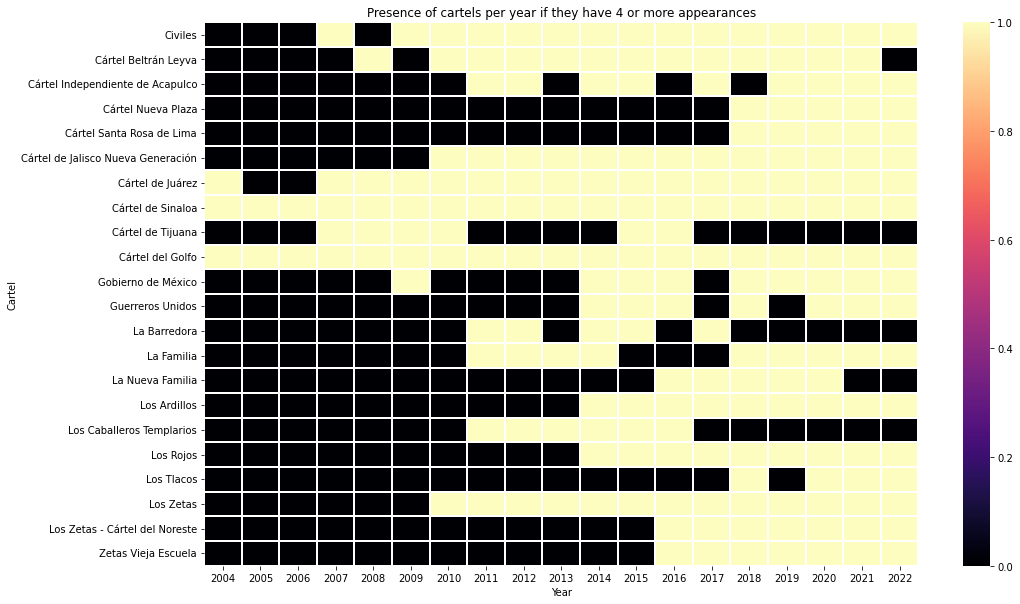

In [27]:
df_calor_aux = pd.DataFrame()
df_calor_aux['date'] = dataframe['date']
df_calor_aux['cart_a'] = dataframe['cart_a']
df_calor_aux['cart_b'] = dataframe['cart_b']
df_calor_aux['muertes'] = dataframe['best_est']
df_calor_aux['year'] = df_calor_aux['date'].dt.year
df_calor_aux1 = pd.DataFrame()
df_calor_aux2 = pd.DataFrame()
df_calor_aux1['year'] = df_calor_aux['year']
df_calor_aux1['cartel'] = df_calor_aux['cart_a']
df_calor_aux2['year'] = df_calor_aux['year']
df_calor_aux2['cartel'] = df_calor_aux['cart_b']
df_calor = pd.concat([df_calor_aux1, df_calor_aux2]).reset_index(drop=True)
df_calor = df_calor.drop_duplicates(subset=['year', 'cartel']).reset_index(drop=True)
# Contar el número de apariciones de cada nombre
nombre_counts = df_calor['cartel'].value_counts()
# Filtrar los nombres que tienen al menos 3 apariciones
carteles_filtrados = nombre_counts[nombre_counts >= 4].index.tolist()
# Filtrar el DataFrame original con los nombres seleccionados
df_calor = df_calor[df_calor['cartel'].isin(carteles_filtrados)]
# Crear una tabla pivote con años como índices, nombres como columnas y contar la ocurrencia
pivot_table = df_calor.pivot_table(index='year', columns='cartel', aggfunc='size', fill_value=0)


# Transponer los datos para invertir los ejes
pivot_table = pivot_table.transpose()


# Graficar el heatmap
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(pivot_table, cmap='magma', annot=False, linewidths=0.01, linecolor='white', fmt='d')
plt.title('Presence of cartels per year if they have 4 or more appearances')
plt.xlabel('Year')
plt.ylabel('Cartel')
# Rotar las etiquetas del eje x en 45 grados
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
# Rotar las etiquetas del eje y en 45 grados
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Heat actividad.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

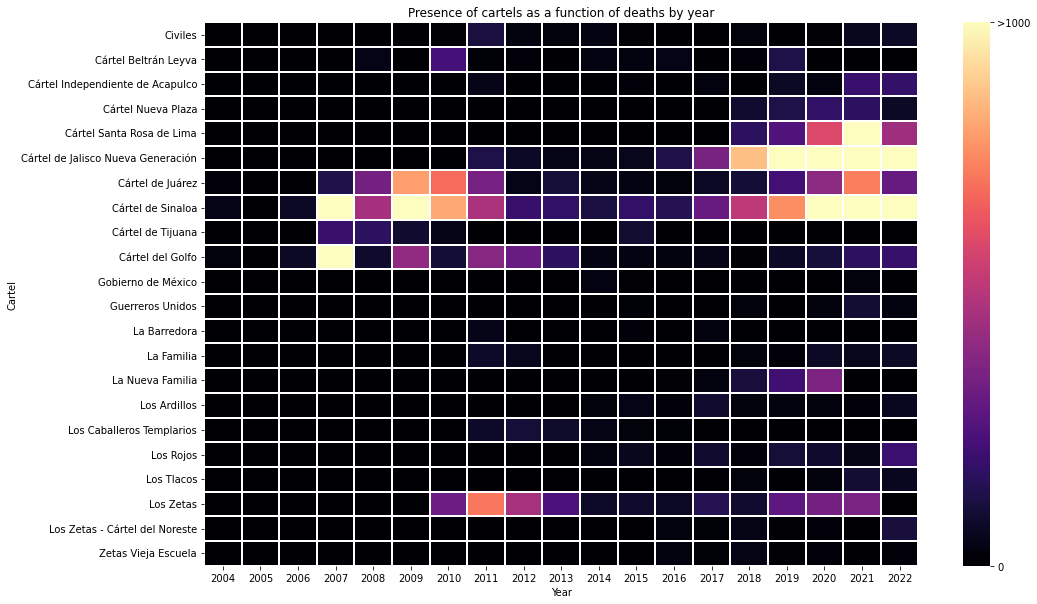

In [28]:
df_calor_aux1 = pd.DataFrame()
df_calor_aux2 = pd.DataFrame()
df_calor_aux1['year'] = df_calor_aux['year']
df_calor_aux1['cartel'] = df_calor_aux['cart_a']
df_calor_aux1['muertes'] = df_calor_aux['muertes']
df_calor_aux2['year'] = df_calor_aux['year']
df_calor_aux2['cartel'] = df_calor_aux['cart_b']
df_calor_aux2['muertes'] = df_calor_aux['muertes']
df_calor_aux_nuevo = pd.concat([df_calor_aux1, df_calor_aux2]).reset_index(drop=True)
# Agrupar por mes, cartel y sumar las muertes asociadas
df_calor_aux_nuevo = df_calor_aux_nuevo.groupby(['year', 'cartel'])['muertes'].sum().reset_index()
# Contar el número de apariciones de cada nombre
nombre_counts2 = df_calor_aux_nuevo['cartel'].value_counts()
# Filtrar los nombres que tienen al menos 3 apariciones
carteles_filtrados2 = nombre_counts2[nombre_counts2 >= 4].index.tolist()
# Filtrar el DataFrame original con los nombres seleccionados
df_calor_aux_nuevo = df_calor_aux_nuevo[df_calor_aux_nuevo['cartel'].isin(carteles_filtrados2)]
# Agrupar por año y nombre, y sumar las muertes
heatmap_data = df_calor_aux_nuevo.groupby(['year', 'cartel'])['muertes'].sum().unstack(fill_value=0)


# Transponer los datos para invertir los ejes
heatmap_data_transpuesta = heatmap_data.transpose()
umbral = 1000
# Aplicar una máscara a los datos para establecer valores por encima del umbral como NaN
heatmap_data_mascara = heatmap_data_transpuesta.where(heatmap_data_transpuesta <= umbral, umbral)



# Graficar el heatmap
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(heatmap_data_mascara, cmap='magma', annot=False, linewidths=0.01, linecolor='white', fmt='g')
### cmap = 'magma'  cmap='YlGnBu'
plt.title('Presence of cartels as a function of deaths by year')
plt.xlabel('Year')
plt.ylabel('Cartel')
# Rotar las etiquetas del eje x en 45 grados
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
# Rotar las etiquetas del eje y en 45 grados
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)


# Añadir una barra de color para la escala
cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, umbral])
cbar.set_ticklabels(['0', f'>{umbral}'])


plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Heat eventos.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

In [29]:
#Analisis de clusters
df_cluster = dataframe
df_cluster['eventos'] = 1
df_cluster['date'] = pd.to_datetime(df_cluster['date'])
# Extraer solo el año y el mes de la columna 'fecha'
df_cluster['date'] = df_cluster['date'].dt.strftime('%Y-%m')
df_cluster = df_cluster.groupby(['date', 'adm_2', 'cart_a', 'cart_b'])['best_est', 'eventos'].sum().reset_index()
df_cluster['date'] = pd.to_datetime(df_cluster['date'])
# Combinar la información utilizando la columna 'municipio' como clave, con unión interna
lista_lat = pd.DataFrame()
lista_lat['adm_2'] = dataframe['adm_2']
lista_lat['latitude'] = dataframe['latitude']
lista_lat['longitude'] = dataframe['longitude']
lista_lat=lista_lat.drop_duplicates().reset_index(drop=True)
for i in tqdm(range(len(df_cluster))):
    for k in range(len(lista_lat)):
        if df_cluster.loc[i,'adm_2'] == lista_lat.loc[k,'adm_2']:
            df_cluster.loc[i,'latitude'] = lista_lat.loc[k,'latitude']
            df_cluster.loc[i,'longitude'] = lista_lat.loc[k,'longitude']


C:\Users\PC\AppData\Local\Temp/ipykernel_21092/631658462.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_cluster = df_cluster.groupby(['date', 'adm_2', 'cart_a', 'cart_b'])['best_est', 'eventos'].sum().reset_index()
100%|██████████████████████████████████████████████████████████████████████████████| 4921/4921 [01:34<00:00, 51.91it/s]


In [30]:
'''
df_cluster_filtro = df_cluster
df_cluster_filtro2 = df_cluster
df_cluster_filtro3 = df_cluster
df_cluster_filtro4 = df_cluster
df_cluster_filtro5 = df_cluster
df_cluster_filtro6 = df_cluster
lista_colores = pd.DataFrame()
# FILTROS
año = 2022
cartel_filtro = 'Jalisco Cartel New Generation'
cartel_filtro2 = 'Sinaloa Cartel'
cartel_filtro3 = 'Juarez Cartel'
cartel_filtro4 = 'Gulf Cartel'
cartel_filtro5 = 'Los Zetas'
cartel_filtro6 = 'Tijuana Cartel'
df_cluster_filtro = df_cluster_filtro[df_cluster_filtro['date'].dt.year == año]
df_cluster_filtro2 = df_cluster_filtro2[df_cluster_filtro2['date'].dt.year == año]
df_cluster_filtro3 = df_cluster_filtro3[df_cluster_filtro3['date'].dt.year == año]
df_cluster_filtro4 = df_cluster_filtro4[df_cluster_filtro4['date'].dt.year == año]
df_cluster_filtro5 = df_cluster_filtro5[df_cluster_filtro5['date'].dt.year == año]
df_cluster_filtro6 = df_cluster_filtro6[df_cluster_filtro6['date'].dt.year == año]
filtro = (df_cluster_filtro['cart_a'] == cartel_filtro) | (df_cluster_filtro['cart_b'] == cartel_filtro)
filtro2 = (df_cluster_filtro2['cart_a'] == cartel_filtro2) | (df_cluster_filtro2['cart_b'] == cartel_filtro2)
filtro3 = (df_cluster_filtro3['cart_a'] == cartel_filtro3) | (df_cluster_filtro3['cart_b'] == cartel_filtro3)
filtro4 = (df_cluster_filtro4['cart_a'] == cartel_filtro4) | (df_cluster_filtro4['cart_b'] == cartel_filtro4)
filtro5 = (df_cluster_filtro5['cart_a'] == cartel_filtro5) | (df_cluster_filtro5['cart_b'] == cartel_filtro5)
filtro6 = (df_cluster_filtro6['cart_a'] == cartel_filtro6) | (df_cluster_filtro6['cart_b'] == cartel_filtro6)
df_cluster_filtro['cartel'] = 'CJNG'
df_cluster_filtro2['cartel'] = 'C. Sinaloa'
df_cluster_filtro3['cartel'] = 'C. Juarez'
df_cluster_filtro4['cartel'] = 'C. Golfo'
df_cluster_filtro5['cartel'] = 'Los Zetas'
df_cluster_filtro6['cartel'] = 'C. Tijuana'
df_cluster_filtro['color'] = 'red'
df_cluster_filtro2['color'] = 'blue'
df_cluster_filtro3['color'] = 'yellow'
df_cluster_filtro4['color'] = 'green'
df_cluster_filtro5['color'] = 'purple'
df_cluster_filtro6['color'] = 'brown'
df_cluster_filtro = df_cluster_filtro[filtro].reset_index(drop=True)
df_cluster_filtro2 = df_cluster_filtro2[filtro2].reset_index(drop=True)
df_cluster_filtro3 = df_cluster_filtro3[filtro3].reset_index(drop=True)
df_cluster_filtro4 = df_cluster_filtro4[filtro4].reset_index(drop=True)
df_cluster_filtro5 = df_cluster_filtro5[filtro5].reset_index(drop=True)
df_cluster_filtro6 = df_cluster_filtro6[filtro6].reset_index(drop=True)
df_cluster_filtro.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\filtro en turno.csv', index=False)
df_cluster_filtro2.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\filtro en turno2.csv', index=False)
df_cluster_filtro3.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\filtro en turno3.csv', index=False)
df_cluster_filtro4.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\filtro en turno4.csv', index=False)
df_cluster_filtro5.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\filtro en turno5.csv', index=False)
df_cluster_filtro6.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\filtro en turno6.csv', index=False)
# Unir los dataframes por columnas y duplicar las filas
df_cluster_filtro_def = pd.concat([df_cluster_filtro, df_cluster_filtro2, df_cluster_filtro3, df_cluster_filtro4, df_cluster_filtro5], ignore_index=True)
df_cluster_filtro_def.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\filtro en turno definitivo.csv', index=False)
lista_colores['color'] = df_cluster_filtro_def['color'].drop_duplicates().reset_index(drop=True)
lista_colores['cartel'] = df_cluster_filtro_def['cartel'].drop_duplicates().reset_index(drop=True)
lista_colores.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\lista colores.csv', index=False)
'''

"\ndf_cluster_filtro = df_cluster\ndf_cluster_filtro2 = df_cluster\ndf_cluster_filtro3 = df_cluster\ndf_cluster_filtro4 = df_cluster\ndf_cluster_filtro5 = df_cluster\ndf_cluster_filtro6 = df_cluster\nlista_colores = pd.DataFrame()\n# FILTROS\naño = 2022\ncartel_filtro = 'Jalisco Cartel New Generation'\ncartel_filtro2 = 'Sinaloa Cartel'\ncartel_filtro3 = 'Juarez Cartel'\ncartel_filtro4 = 'Gulf Cartel'\ncartel_filtro5 = 'Los Zetas'\ncartel_filtro6 = 'Tijuana Cartel'\ndf_cluster_filtro = df_cluster_filtro[df_cluster_filtro['date'].dt.year == año]\ndf_cluster_filtro2 = df_cluster_filtro2[df_cluster_filtro2['date'].dt.year == año]\ndf_cluster_filtro3 = df_cluster_filtro3[df_cluster_filtro3['date'].dt.year == año]\ndf_cluster_filtro4 = df_cluster_filtro4[df_cluster_filtro4['date'].dt.year == año]\ndf_cluster_filtro5 = df_cluster_filtro5[df_cluster_filtro5['date'].dt.year == año]\ndf_cluster_filtro6 = df_cluster_filtro6[df_cluster_filtro6['date'].dt.year == año]\nfiltro = (df_cluster_filtro['

In [31]:
############# COMPARACIONES ENTRE SEXENIOS, CALDERÓN, PEÑA Y OBRADOR (COMIENZO)
inicio1 = pd.Timestamp(year=2006, month=12, day=1)  # Inicio de diciembre de 2006
fin1 = pd.Timestamp(year=2012, month=11, day=30)    # Fin de noviembre de 2012
filtrocalderon = (dataframe['date_start_2'] >= inicio1) & (dataframe['date_start_2'] <= fin1)
datacalderon = dataframe[filtrocalderon].copy().reset_index(drop=True)

inicio2 = pd.Timestamp(year=2012, month=12, day=1)  
fin2 = pd.Timestamp(year=2018, month=11, day=30)    
filtronieto = (dataframe['date_start_2'] >= inicio2) & (dataframe['date_start_2'] <= fin2)
datanieto = dataframe[filtronieto].copy().reset_index(drop=True)

inicio3 = pd.Timestamp(year=2018, month=12, day=1) 
fin3 = pd.Timestamp(year=2022, month=12, day=30)   
filtroobrador = (dataframe['date_start_2'] >= inicio3) & (dataframe['date_start_2'] <= fin3)
dataobrador = dataframe[filtroobrador].copy().reset_index(drop=True)

In [32]:
suma_eventos_cal= datacalderon['evento'].sum()
suma_eventos_nie= datanieto['evento'].sum()
suma_eventos_obr= dataobrador['evento'].sum()
print("Los eventos Calderón:", suma_eventos_cal, "Los eventos Peña:", suma_eventos_nie, "Los eventos Obrador:", suma_eventos_obr)

Los eventos Calderón: 2870 Los eventos Peña: 1400 Los eventos Obrador: 8474


In [33]:
suma_muertos_cal= datacalderon['best_est'].sum()
suma_muertos_nie= datanieto['best_est'].sum()
suma_muertos_obr= dataobrador['best_est'].sum()
print("Los muertos Calderón:", suma_muertos_cal, "Los muertos Peña:", suma_muertos_nie, "Los muertos Obrador:", suma_muertos_obr)

Los muertos Calderón: 6630 Los muertos Peña: 3260 Los muertos Obrador: 14007


In [34]:
suma_estados_cal= datacalderon['adm_1'].nunique()
suma_estados_nie= datanieto['adm_1'].nunique()
suma_estados_obr= dataobrador['adm_1'].nunique()
print("Edos afec. Calderón:", suma_estados_cal, "Edos afec. Peña:", suma_estados_nie, "Edos afec. Obrador:", suma_estados_obr)

Edos afec. Calderón: 25 Edos afec. Peña: 24 Edos afec. Obrador: 28


In [35]:
# Combinar las dos columnas de nombres en una sola Serie
serie_nombres1 = pd.concat([datacalderon['cart_a'], datacalderon['cart_b']])
serie_nombres2 = pd.concat([datanieto['cart_a'], datanieto['cart_b']])

suma_carteles_cal= serie_nombres1.nunique()
suma_carteles_nie= serie_nombres2.nunique()

print("Los cárteles activos durante el sex. de Calderón son:", suma_carteles_cal, "Los cárteles activos durante el sex. de Peña son:", suma_carteles_nie)

Los cárteles activos durante el sex. de Calderón son: 20 Los cárteles activos durante el sex. de Peña son: 39


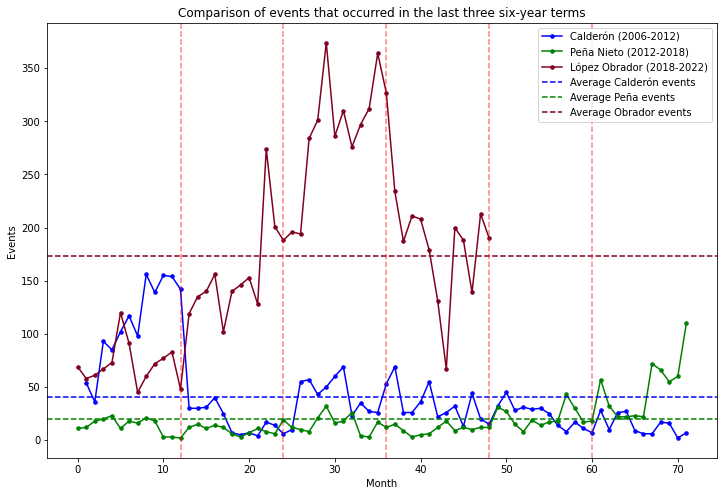

In [36]:
#Comparación de los eventos entre ambos sexenios EVENTOS

eventos_calderon = datacalderon.groupby(['date'])['evento'].sum().reset_index()
eventos_nieto = datanieto.groupby(['date'])['evento'].sum().reset_index()
eventos_obrador = dataobrador.groupby(['date'])['evento'].sum().reset_index()
eventos_calderon['date'] = pd.to_datetime(eventos_calderon['date'], format='%Y/%m')
eventos_nieto['date'] = pd.to_datetime(eventos_nieto['date'], format='%Y/%m')
eventos_obrador['date'] = pd.to_datetime(eventos_obrador['date'], format='%Y/%m')

# Extraer el año de la columna 'tiempo'
eventos_calderon['año'] = eventos_calderon['date'].dt.year# Extraer el año de la columna 'tiempo'
eventos_nieto['año'] = eventos_nieto['date'].dt.year
eventos_obrador['año'] = eventos_obrador['date'].dt.year
# Extraer el mes de la columna 'tiempo'
eventos_calderon['mes'] = eventos_calderon['date'].dt.month# Extraer el mes de la columna 'tiempo'
eventos_nieto['mes'] = eventos_nieto['date'].dt.month
eventos_obrador['mes'] = eventos_obrador['date'].dt.month

for i in range(len(eventos_calderon)):
    eventos_calderon.loc[i, 'mes_tot'] = eventos_calderon.loc[i, 'mes'] + (eventos_calderon.loc[i, 'año'] - 2007)*12 
for i in range(len(eventos_nieto)):
    eventos_nieto.loc[i, 'mes_tot'] = eventos_nieto.loc[i, 'mes'] + (eventos_nieto.loc[i, 'año'] - 2013)*12 
for i in range(len(eventos_obrador)):
    eventos_obrador.loc[i, 'mes_tot'] = eventos_obrador.loc[i, 'mes'] + (eventos_obrador.loc[i, 'año'] - 2019)*12 
    
eventos_calderon['mes_tot'] = eventos_calderon['mes_tot'].astype(int)
eventos_nieto['mes_tot'] = eventos_nieto['mes_tot'].astype(int)
eventos_obrador['mes_tot'] = eventos_obrador['mes_tot'].astype(int)

# Calcula el promedio de los datos de la primera línea
promedio_linea1 = eventos_calderon['evento'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = eventos_nieto['evento'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea3 = eventos_obrador['evento'].mean()

# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(eventos_calderon['mes_tot'], eventos_calderon['evento'], label='Calderón (2006-2012)', marker='o', markersize=3.5, color='blue')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(eventos_nieto['mes_tot'], eventos_nieto['evento'], label='Peña Nieto (2012-2018)', marker='o', markersize=3.5, color='green')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(eventos_obrador['mes_tot'], eventos_obrador['evento'], label='López Obrador (2018-2022)', marker='o', markersize=3.5, color='#800020')

# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='blue', linestyle='--', label='Average Calderón events'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='green', linestyle='--', label='Average Peña events'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#800020', linestyle='--', label='Average Obrador events'.format(promedio_linea3))

# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, eventos_calderon['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12

# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Events')
ax.set_title('Comparison of events that occurred in the last three six-year terms')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor

ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios eventos.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

# Mostrar la gráfica
plt.show()

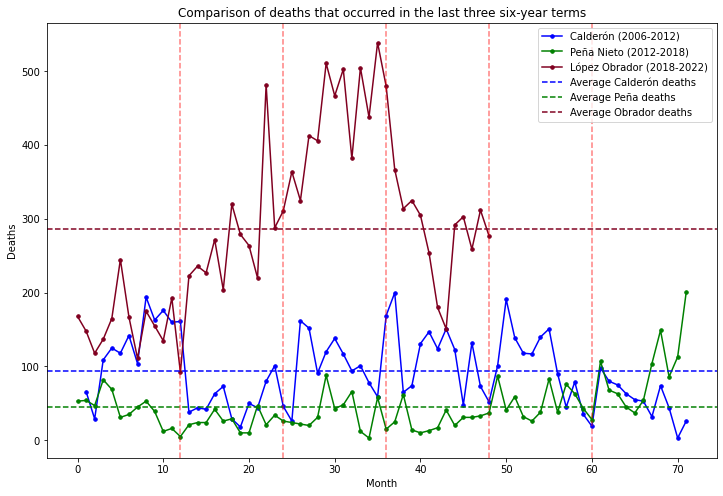

In [37]:
#Comparación de los eventos entre ambos sexenios MUERTOS

muertos_calderon = datacalderon.groupby(['date'])['best_est'].sum().reset_index()
muertos_nieto = datanieto.groupby(['date'])['best_est'].sum().reset_index()
muertos_obrador = dataobrador.groupby(['date'])['best_est'].sum().reset_index()
muertos_calderon['date'] = pd.to_datetime(muertos_calderon['date'], format='%Y/%m')
muertos_nieto['date'] = pd.to_datetime(muertos_nieto['date'], format='%Y/%m')
muertos_obrador['date'] = pd.to_datetime(muertos_obrador['date'], format='%Y/%m')

# Extraer el año de la columna 'tiempo'
muertos_calderon['año'] = muertos_calderon['date'].dt.year# Extraer el año de la columna 'tiempo'
muertos_nieto['año'] = muertos_nieto['date'].dt.year
muertos_obrador['año'] = muertos_obrador['date'].dt.year
# Extraer el mes de la columna 'tiempo'
muertos_calderon['mes'] = muertos_calderon['date'].dt.month# Extraer el mes de la columna 'tiempo'
muertos_nieto['mes'] = muertos_nieto['date'].dt.month
muertos_obrador['mes'] = muertos_obrador['date'].dt.month

for i in range(len(muertos_calderon)):
    muertos_calderon.loc[i, 'mes_tot'] = muertos_calderon.loc[i, 'mes'] + (muertos_calderon.loc[i, 'año'] - 2007)*12 
for i in range(len(muertos_nieto)):
    muertos_nieto.loc[i, 'mes_tot'] = muertos_nieto.loc[i, 'mes'] + (muertos_nieto.loc[i, 'año'] - 2013)*12 
for i in range(len(muertos_obrador)):
    muertos_obrador.loc[i, 'mes_tot'] = muertos_obrador.loc[i, 'mes'] + (muertos_obrador.loc[i, 'año'] - 2019)*12 
    
muertos_calderon['mes_tot'] = muertos_calderon['mes_tot'].astype(int)
muertos_nieto['mes_tot'] = muertos_nieto['mes_tot'].astype(int)
muertos_obrador['mes_tot'] = muertos_obrador['mes_tot'].astype(int)

# Calcula el promedio de los datos de la primera línea
promedio_linea1 = muertos_calderon['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = muertos_nieto['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea3 = muertos_obrador['best_est'].mean()

# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(muertos_calderon['mes_tot'], muertos_calderon['best_est'], label='Calderón (2006-2012)', marker='o', markersize=3.5, color='blue')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(muertos_nieto['mes_tot'], muertos_nieto['best_est'], label='Peña Nieto (2012-2018)', marker='o', markersize=3.5, color='green')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(muertos_obrador['mes_tot'], muertos_obrador['best_est'], label='López Obrador (2018-2022)', marker='o', markersize=3.5, color='#800020')

# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='blue', linestyle='--', label='Average Calderón deaths'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='green', linestyle='--', label='Average Peña deaths'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#800020', linestyle='--', label='Average Obrador deaths'.format(promedio_linea3))


# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, muertos_calderon['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12

# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Deaths')
ax.set_title('Comparison of deaths that occurred in the last three six-year terms')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor

ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios muertes.png', dpi = 300, bbox_inches='tight', pad_inches=0.05)
# Mostrar la gráfica
plt.show()

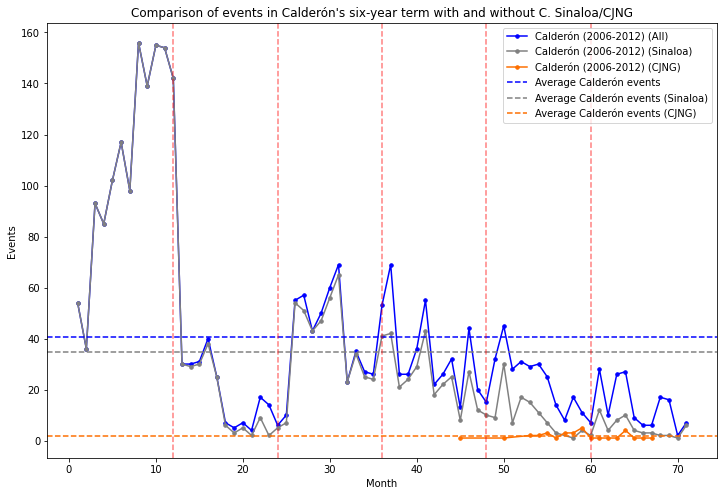

In [38]:
#CREAMOS UN DF CON INFORMACION SOLO DEL CARTEL DE SINALOA EN EL SEXENIO DE CALDERON
filtro_sinaloa = datacalderon['cart_a'].str.contains('Cártel de Sinaloa', case=False) | datacalderon['cart_b'].str.contains('Cártel de Sinaloa', case=False)
sinaloa_calderon_fin = datacalderon[filtro_sinaloa].reset_index(drop=True)
#CREAMOS UN DF CON INFORMACION SOLO DEL CJNG EN EL SEXENIO DE CALDERON
filtro_cjng = datacalderon['cart_a'].str.contains('Cártel de Jalisco Nueva Generación', case=False) | datacalderon['cart_b'].str.contains('Cártel de Jalisco Nueva Generación', case=False)
scjng_calderon_fin = datacalderon[filtro_cjng].reset_index(drop=True)


#'''            
#Agrupamos por mes que es como irá la gráfica
sinaloa_calderon_fin = sinaloa_calderon_fin.groupby(['date'])['evento'].sum().reset_index()
scjng_calderon_fin = scjng_calderon_fin.groupby(['date'])['evento'].sum().reset_index()


#volvemos date a to date time para extraer año y fecha
sinaloa_calderon_fin['date'] = pd.to_datetime(sinaloa_calderon_fin['date'], format='%Y/%m')
sinaloa_calderon_fin['año'] = sinaloa_calderon_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
sinaloa_calderon_fin['mes'] = sinaloa_calderon_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'
scjng_calderon_fin['date'] = pd.to_datetime(scjng_calderon_fin['date'], format='%Y/%m')
scjng_calderon_fin['año'] = scjng_calderon_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
scjng_calderon_fin['mes'] = scjng_calderon_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'


#Contamos los meses de 1 hasta el tope de la base para que no se repitan modulo 12
for i in range(len(sinaloa_calderon_fin)):
    sinaloa_calderon_fin.loc[i, 'mes_tot'] = sinaloa_calderon_fin.loc[i, 'mes'] + (sinaloa_calderon_fin.loc[i, 'año'] - 2007)*12 
sinaloa_calderon_fin['mes_tot'] = sinaloa_calderon_fin['mes_tot'].astype(int)

for i in range(len(scjng_calderon_fin)):
    scjng_calderon_fin.loc[i, 'mes_tot'] = scjng_calderon_fin.loc[i, 'mes'] + (scjng_calderon_fin.loc[i, 'año'] - 2007)*12 
scjng_calderon_fin['mes_tot'] = scjng_calderon_fin['mes_tot'].astype(int)

# Calcula el promedio de los datos de la primera línea
promedio_linea1 = eventos_calderon['evento'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = sinaloa_calderon_fin['evento'].mean()
# Calcula el promedio de los datos de la tercera línea
promedio_linea3 = scjng_calderon_fin['evento'].mean()


# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(eventos_calderon['mes_tot'], eventos_calderon['evento'], label='Calderón (2006-2012) (All)', marker='o', markersize=3.5, color='blue')
# Graficar los datos del segundo DataFrame
ax.plot(sinaloa_calderon_fin['mes_tot'], sinaloa_calderon_fin['evento'], label='Calderón (2006-2012) (Sinaloa)', marker='o', markersize=3.5, color='gray')
# Graficar los datos del tercer DataFrame 
ax.plot(scjng_calderon_fin['mes_tot'], scjng_calderon_fin['evento'], label='Calderón (2006-2012) (CJNG)', marker='o', markersize=3.5, color='#FD6F00')

# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='blue', linestyle='--', label='Average Calderón events'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='gray', linestyle='--', label='Average Calderón events (Sinaloa)'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#FD6F00', linestyle='--', label='Average Calderón events (CJNG)'.format(promedio_linea3))

# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, eventos_calderon['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12
# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Events')
ax.set_title('Comparison of events in Calderón\'s six-year term with and without C. Sinaloa/CJNG')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor
ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios eventos Sinaloa Calderon.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
# Mostrar la gráfica
plt.show()

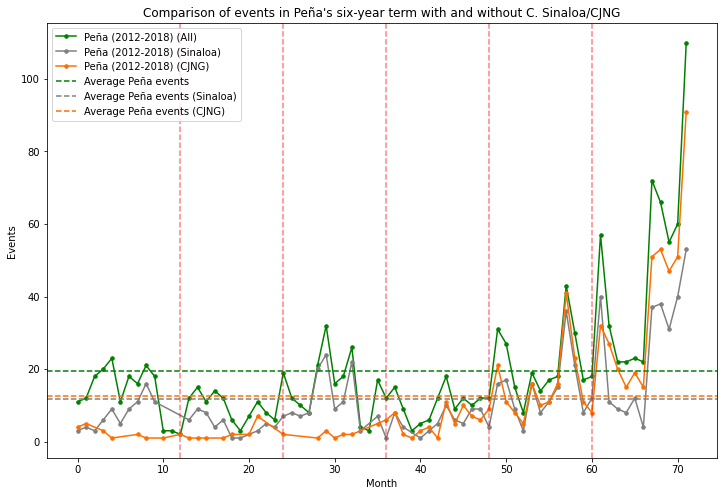

In [39]:
#CREAMOS UN DF CON INFORMACION SOLO DEL CARTEL DE SINALOA EN EL SEXENIO DE PEÑA
filtro_sinaloa2 = datanieto['cart_a'].str.contains('Cártel de Sinaloa', case=False) | datanieto['cart_b'].str.contains('Cártel de Sinaloa', case=False)
sinaloa_nieto_fin = datanieto[filtro_sinaloa2].reset_index(drop=True)
filtro_cjng2 = datanieto['cart_a'].str.contains('Cártel de Jalisco Nueva Generación', case=False) | datanieto['cart_b'].str.contains('Cártel de Jalisco Nueva Generación', case=False)
cjng_nieto_fin = datanieto[filtro_cjng2].reset_index(drop=True)

#Agrupamos por mes que es como irá la gráfica
sinaloa_nieto_fin = sinaloa_nieto_fin.groupby(['date'])['evento'].sum().reset_index()
cjng_nieto_fin = cjng_nieto_fin.groupby(['date'])['evento'].sum().reset_index()
#volvemos date a to date time para extraer año y fecha
sinaloa_nieto_fin['date'] = pd.to_datetime(sinaloa_nieto_fin['date'], format='%Y/%m')
sinaloa_nieto_fin['año'] = sinaloa_nieto_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
sinaloa_nieto_fin['mes'] = sinaloa_nieto_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'
cjng_nieto_fin['date'] = pd.to_datetime(cjng_nieto_fin['date'], format='%Y/%m')
cjng_nieto_fin['año'] = cjng_nieto_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
cjng_nieto_fin['mes'] = cjng_nieto_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'

for i in range(len(sinaloa_nieto_fin)):
    sinaloa_nieto_fin.loc[i, 'mes_tot'] = sinaloa_nieto_fin.loc[i, 'mes'] + (sinaloa_nieto_fin.loc[i, 'año'] - 2013)*12 
sinaloa_nieto_fin['mes_tot'] = sinaloa_nieto_fin['mes_tot'].astype(int)
for i in range(len(cjng_nieto_fin)):
    cjng_nieto_fin.loc[i, 'mes_tot'] = cjng_nieto_fin.loc[i, 'mes'] + (cjng_nieto_fin.loc[i, 'año'] - 2013)*12 
cjng_nieto_fin['mes_tot'] = cjng_nieto_fin['mes_tot'].astype(int)


# Calcula el promedio de los datos de la primera línea
promedio_linea1 = eventos_nieto['evento'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = sinaloa_nieto_fin['evento'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea3 = cjng_nieto_fin['evento'].mean()

# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(eventos_nieto['mes_tot'], eventos_nieto['evento'], label='Peña (2012-2018) (All)', marker='o', markersize=3.5, color='green')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(sinaloa_nieto_fin['mes_tot'], sinaloa_nieto_fin['evento'], label='Peña (2012-2018) (Sinaloa)', marker='o', markersize=3.5, color='gray')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(cjng_nieto_fin['mes_tot'], cjng_nieto_fin['evento'], label='Peña (2012-2018) (CJNG)', marker='o', markersize=3.5, color='#FD6F00')

# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='green', linestyle='--', label='Average Peña events'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='gray', linestyle='--', label='Average Peña events (Sinaloa)'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#FD6F00', linestyle='--', label='Average Peña events (CJNG)'.format(promedio_linea3))


# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, eventos_nieto['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12

# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Events')
ax.set_title('Comparison of events in Peña\'s six-year term with and without C. Sinaloa/CJNG')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor

ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios eventos Sinaloa Pena.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
# Mostrar la gráfica
plt.show()

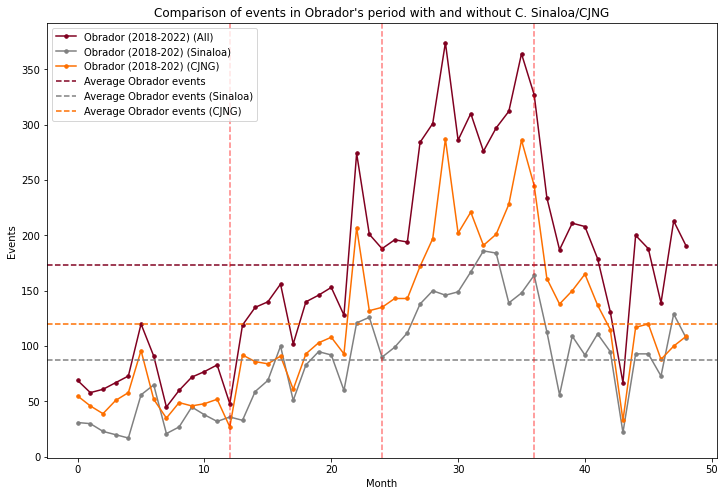

In [40]:
#CREAMOS UN DF CON INFORMACION SOLO DEL CARTEL DE SINALOA EN EL SEXENIO DE PEÑA
filtro_sinaloa3 = dataobrador['cart_a'].str.contains('Cártel de Sinaloa', case=False) | dataobrador['cart_b'].str.contains('Cártel de Sinaloa', case=False)
sinaloa_obrador_fin = dataobrador[filtro_sinaloa3].reset_index(drop=True)
filtro_cjng3 = dataobrador['cart_a'].str.contains('Cártel de Jalisco Nueva Generación', case=False) | dataobrador['cart_b'].str.contains('Cártel de Jalisco Nueva Generación', case=False)
cjng_obrador_fin = dataobrador[filtro_cjng3].reset_index(drop=True)

#Agrupamos por mes que es como irá la gráfica
sinaloa_obrador_fin = sinaloa_obrador_fin.groupby(['date'])['evento'].sum().reset_index()
cjng_obrador_fin = cjng_obrador_fin.groupby(['date'])['evento'].sum().reset_index()

#volvemos date a to date time para extraer año y fecha
sinaloa_obrador_fin['date'] = pd.to_datetime(sinaloa_obrador_fin['date'], format='%Y/%m')
sinaloa_obrador_fin['año'] = sinaloa_obrador_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
sinaloa_obrador_fin['mes'] = sinaloa_obrador_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'
cjng_obrador_fin['date'] = pd.to_datetime(cjng_obrador_fin['date'], format='%Y/%m')
cjng_obrador_fin['año'] = cjng_obrador_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
cjng_obrador_fin['mes'] = cjng_obrador_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'

for i in range(len(sinaloa_obrador_fin)):
    sinaloa_obrador_fin.loc[i, 'mes_tot'] = sinaloa_obrador_fin.loc[i, 'mes'] + (sinaloa_obrador_fin.loc[i, 'año'] - 2019)*12 
sinaloa_obrador_fin['mes_tot'] = sinaloa_obrador_fin['mes_tot'].astype(int)
for i in range(len(cjng_obrador_fin)):
    cjng_obrador_fin.loc[i, 'mes_tot'] = cjng_obrador_fin.loc[i, 'mes'] + (cjng_obrador_fin.loc[i, 'año'] - 2019)*12 
cjng_obrador_fin['mes_tot'] = cjng_obrador_fin['mes_tot'].astype(int)

# Calcula el promedio de los datos de la primera línea
promedio_linea1 = eventos_obrador['evento'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = sinaloa_obrador_fin['evento'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea3 = cjng_obrador_fin['evento'].mean()

# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(eventos_obrador['mes_tot'], eventos_obrador['evento'], label='Obrador (2018-2022) (All)', marker='o', markersize=3.5, color='#800020')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(sinaloa_obrador_fin['mes_tot'], sinaloa_obrador_fin['evento'], label='Obrador (2018-202) (Sinaloa)', marker='o', markersize=3.5, color='gray')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(cjng_obrador_fin['mes_tot'], cjng_obrador_fin['evento'], label='Obrador (2018-202) (CJNG)', marker='o', markersize=3.5, color='#FD6F00')

# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='#800020', linestyle='--', label='Average Obrador events'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='gray', linestyle='--', label='Average Obrador events (Sinaloa)'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#FD6F00', linestyle='--', label='Average Obrador events (CJNG)'.format(promedio_linea3))


# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, eventos_obrador['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12

# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Events')
ax.set_title('Comparison of events in Obrador\'s period with and without C. Sinaloa/CJNG')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor

ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios eventos Sinaloa Obrador.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
# Mostrar la gráfica
plt.show()

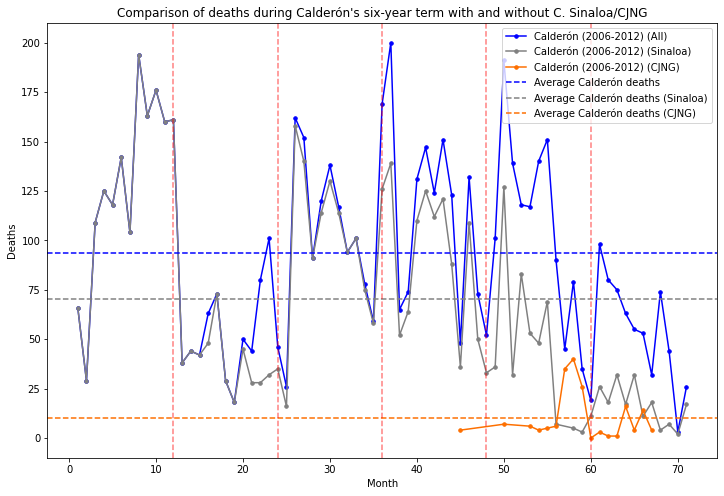

In [41]:
#CREAMOS UN DF CON INFORMACION SOLO DEL CARTEL DE SINALOA EN EL SEXENIO DE CALDERON
sinaloa_calderon_fin = pd.DataFrame()
filtro_sinaloa = datacalderon['cart_a'].str.contains('Cártel de Sinaloa', case=False) | datacalderon['cart_b'].str.contains('Cártel de Sinaloa', case=False)
sinaloa_calderon_fin = datacalderon[filtro_sinaloa].reset_index(drop=True)
cjng_calderon_fin = pd.DataFrame()
filtro_cjng = datacalderon['cart_a'].str.contains('Cártel de Jalisco Nueva Generación', case=False) | datacalderon['cart_b'].str.contains('Cártel de Jalisco Nueva Generación', case=False)
cjng_calderon_fin = datacalderon[filtro_cjng].reset_index(drop=True)
#''' 
#Agrupamos por mes que es como irá la gráfica
sinaloa_calderon_fin = sinaloa_calderon_fin.groupby(['date'])['best_est'].sum().reset_index()
cjng_calderon_fin = cjng_calderon_fin.groupby(['date'])['best_est'].sum().reset_index()

#volvemos date a to date time para extraer año y fecha
sinaloa_calderon_fin['date'] = pd.to_datetime(sinaloa_calderon_fin['date'], format='%Y/%m')
sinaloa_calderon_fin['año'] = sinaloa_calderon_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
sinaloa_calderon_fin['mes'] = sinaloa_calderon_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'
cjng_calderon_fin['date'] = pd.to_datetime(cjng_calderon_fin['date'], format='%Y/%m')
cjng_calderon_fin['año'] = cjng_calderon_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
cjng_calderon_fin['mes'] = cjng_calderon_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'
#Contamos los meses de 1 hasta el tope de la base para que no se repitan modulo 12
for i in range(len(sinaloa_calderon_fin)):
    sinaloa_calderon_fin.loc[i, 'mes_tot'] = sinaloa_calderon_fin.loc[i, 'mes'] + (sinaloa_calderon_fin.loc[i, 'año'] - 2007)*12 
sinaloa_calderon_fin['mes_tot'] = sinaloa_calderon_fin['mes_tot'].astype(int)
for i in range(len(cjng_calderon_fin)):
    cjng_calderon_fin.loc[i, 'mes_tot'] = cjng_calderon_fin.loc[i, 'mes'] + (cjng_calderon_fin.loc[i, 'año'] - 2007)*12 
cjng_calderon_fin['mes_tot'] = cjng_calderon_fin['mes_tot'].astype(int)
# Calcula el promedio de los datos de la primera línea
promedio_linea1 = muertos_calderon['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = sinaloa_calderon_fin['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea3 = cjng_calderon_fin['best_est'].mean()
# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(muertos_calderon['mes_tot'], muertos_calderon['best_est'], label='Calderón (2006-2012) (All)', marker='o', markersize=3.5, color='blue')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(sinaloa_calderon_fin['mes_tot'], sinaloa_calderon_fin['best_est'], label='Calderón (2006-2012) (Sinaloa)', marker='o', markersize=3.5, color='gray')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(cjng_calderon_fin['mes_tot'], cjng_calderon_fin['best_est'], label='Calderón (2006-2012) (CJNG)', marker='o', markersize=3.5, color='#FD6F00')

# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='blue', linestyle='--', label='Average Calderón deaths'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='gray', linestyle='--', label='Average Calderón deaths (Sinaloa)'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#FD6F00', linestyle='--', label='Average Calderón deaths (CJNG)'.format(promedio_linea3))

# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, muertos_calderon['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12
# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Deaths')
ax.set_title('Comparison of deaths during Calderón\'s six-year term with and without C. Sinaloa/CJNG')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor
ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios muertos Sinaloa Calderon.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
# Mostrar la gráfica
plt.show()
#'''
#sinaloa_calderon_fin.head(-1)

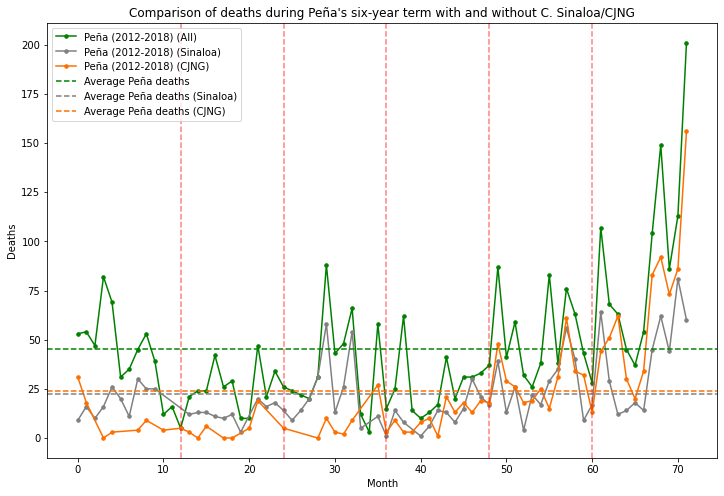

In [42]:
#CREAMOS UN DF CON INFORMACION SOLO DEL CARTEL DE SINALOA EN EL SEXENIO DE PEÑA
sinaloa_nieto_fin = pd.DataFrame()
filtro_sinaloa2 = datanieto['cart_a'].str.contains('Cártel de Sinaloa', case=False) | datanieto['cart_b'].str.contains('Cártel de Sinaloa', case=False)
sinaloa_nieto_fin = datanieto[filtro_sinaloa2].reset_index(drop=True)
cjng_nieto_fin = pd.DataFrame()
filtro_cjng2 = datanieto['cart_a'].str.contains('Cártel de Jalisco Nueva Generación', case=False) | datanieto['cart_b'].str.contains('Cártel de Jalisco Nueva Generación', case=False)
cjng_nieto_fin = datanieto[filtro_cjng2].reset_index(drop=True)

#Agrupamos por mes que es como irá la gráfica
sinaloa_nieto_fin = sinaloa_nieto_fin.groupby(['date'])['best_est'].sum().reset_index()
cjng_nieto_fin = cjng_nieto_fin.groupby(['date'])['best_est'].sum().reset_index()

#volvemos date a to date time para extraer año y fecha
sinaloa_nieto_fin['date'] = pd.to_datetime(sinaloa_nieto_fin['date'], format='%Y/%m')
sinaloa_nieto_fin['año'] = sinaloa_nieto_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
sinaloa_nieto_fin['mes'] = sinaloa_nieto_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'
cjng_nieto_fin['date'] = pd.to_datetime(cjng_nieto_fin['date'], format='%Y/%m')
cjng_nieto_fin['año'] = cjng_nieto_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
cjng_nieto_fin['mes'] = cjng_nieto_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'

for i in range(len(sinaloa_nieto_fin)):
    sinaloa_nieto_fin.loc[i, 'mes_tot'] = sinaloa_nieto_fin.loc[i, 'mes'] + (sinaloa_nieto_fin.loc[i, 'año'] - 2013)*12 
sinaloa_nieto_fin['mes_tot'] = sinaloa_nieto_fin['mes_tot'].astype(int)
for i in range(len(cjng_nieto_fin)):
    cjng_nieto_fin.loc[i, 'mes_tot'] = cjng_nieto_fin.loc[i, 'mes'] + (cjng_nieto_fin.loc[i, 'año'] - 2013)*12 
cjng_nieto_fin['mes_tot'] = cjng_nieto_fin['mes_tot'].astype(int)

# Calcula el promedio de los datos de la primera línea
promedio_linea1 = muertos_nieto['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = sinaloa_nieto_fin['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea3 = cjng_nieto_fin['best_est'].mean()

# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(muertos_nieto['mes_tot'], muertos_nieto['best_est'], label='Peña (2012-2018) (All)', marker='o', markersize=3.5, color='green')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(sinaloa_nieto_fin['mes_tot'], sinaloa_nieto_fin['best_est'], label='Peña (2012-2018) (Sinaloa)', marker='o', markersize=3.5, color='gray')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(cjng_nieto_fin['mes_tot'], cjng_nieto_fin['best_est'], label='Peña (2012-2018) (CJNG)', marker='o', markersize=3.5, color='#FD6F00')

# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='green', linestyle='--', label='Average Peña deaths'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='gray', linestyle='--', label='Average Peña deaths (Sinaloa)'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#FD6F00', linestyle='--', label='Average Peña deaths (CJNG)'.format(promedio_linea3))


# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, muertos_nieto['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12

# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Deaths')
ax.set_title('Comparison of deaths during Peña\'s six-year term with and without C. Sinaloa/CJNG')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor

ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios muertos Sinaloa Pena.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
# Mostrar la gráfica
plt.show()

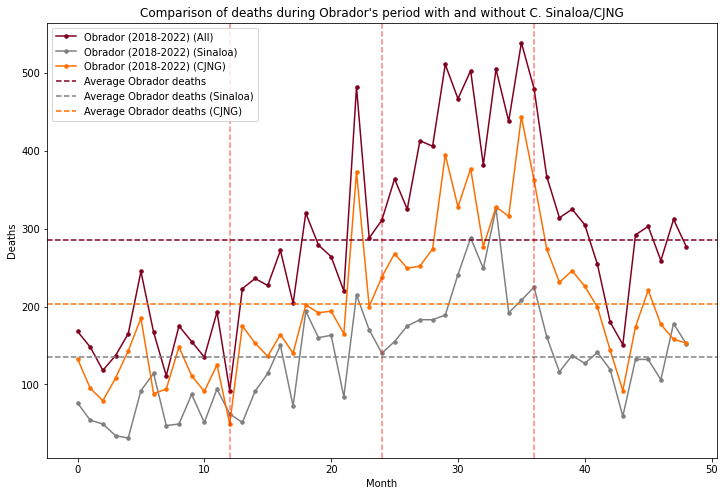

In [43]:
#CREAMOS UN DF CON INFORMACION SOLO DEL CARTEL DE SINALOA EN EL SEXENIO DE PEÑA
sinaloa_obrador_fin = pd.DataFrame()
filtro_sinaloa3 = dataobrador['cart_a'].str.contains('Cártel de Sinaloa', case=False) | dataobrador['cart_b'].str.contains('Cártel de Sinaloa', case=False)
sinaloa_obrador_fin = dataobrador[filtro_sinaloa3].reset_index(drop=True)
cjng_obrador_fin = pd.DataFrame()
filtro_cjng3 = dataobrador['cart_a'].str.contains('Cártel de Jalisco Nueva Generación', case=False) | dataobrador['cart_b'].str.contains('Cártel de Jalisco Nueva Generación', case=False)
cjng_obrador_fin = dataobrador[filtro_cjng3].reset_index(drop=True)

#Agrupamos por mes que es como irá la gráfica
sinaloa_obrador_fin = sinaloa_obrador_fin.groupby(['date'])['best_est'].sum().reset_index()
cjng_obrador_fin = cjng_obrador_fin.groupby(['date'])['best_est'].sum().reset_index()

#volvemos date a to date time para extraer año y fecha
sinaloa_obrador_fin['date'] = pd.to_datetime(sinaloa_obrador_fin['date'], format='%Y/%m')
sinaloa_obrador_fin['año'] = sinaloa_obrador_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
sinaloa_obrador_fin['mes'] = sinaloa_obrador_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'
cjng_obrador_fin['date'] = pd.to_datetime(cjng_obrador_fin['date'], format='%Y/%m')
cjng_obrador_fin['año'] = cjng_obrador_fin['date'].dt.year# Extraer el año de la columna 'tiempo'
cjng_obrador_fin['mes'] = cjng_obrador_fin['date'].dt.month# Extraer el mes de la columna 'tiempo'

for i in range(len(sinaloa_obrador_fin)):
    sinaloa_obrador_fin.loc[i, 'mes_tot'] = sinaloa_obrador_fin.loc[i, 'mes'] + (sinaloa_obrador_fin.loc[i, 'año'] - 2019)*12 
sinaloa_obrador_fin['mes_tot'] = sinaloa_obrador_fin['mes_tot'].astype(int)
for i in range(len(cjng_obrador_fin)):
    cjng_obrador_fin.loc[i, 'mes_tot'] = cjng_obrador_fin.loc[i, 'mes'] + (cjng_obrador_fin.loc[i, 'año'] - 2019)*12 
cjng_obrador_fin['mes_tot'] = cjng_obrador_fin['mes_tot'].astype(int)

# Calcula el promedio de los datos de la primera línea
promedio_linea1 = muertos_obrador['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea2 = sinaloa_obrador_fin['best_est'].mean()
# Calcula el promedio de los datos de la segunda línea
promedio_linea3 = cjng_obrador_fin['best_est'].mean()

# Crear una figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(12, 8))
# Graficar los datos del primer DataFrame (2006-2012)
ax.plot(muertos_obrador['mes_tot'], muertos_obrador['best_est'], label='Obrador (2018-2022) (All)', marker='o', markersize=3.5, color='#800020')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(sinaloa_obrador_fin['mes_tot'], sinaloa_obrador_fin['best_est'], label='Obrador (2018-2022) (Sinaloa)', marker='o', markersize=3.5, color='gray')
# Graficar los datos del segundo DataFrame (2012-2018)
ax.plot(cjng_obrador_fin['mes_tot'], cjng_obrador_fin['best_est'], label='Obrador (2018-2022) (CJNG)', marker='o', markersize=3.5, color='#FD6F00')


# Agrega las líneas de promedio a la gráfica existente
plt.axhline(y=promedio_linea1, color='#800020', linestyle='--', label='Average Obrador deaths'.format(promedio_linea1))
plt.axhline(y=promedio_linea2, color='gray', linestyle='--', label='Average Obrador deaths (Sinaloa)'.format(promedio_linea2))
plt.axhline(y=promedio_linea3, color='#FD6F00', linestyle='--', label='Average Obrador deaths (CJNG)'.format(promedio_linea3))


# LIENAS DE AÑOS CADA 12 MESES"
for i in range(12, muertos_obrador['mes_tot'].max(), 12):
    ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)  # Línea vertical en múltiplos de 12

# Añadir etiquetas y leyenda
ax.set_xlabel('Month')
ax.set_ylabel('Deaths')
ax.set_title('Comparison of deaths during Obrador\'s period with and without C. Sinaloa/CJNG')
#plt.grid(which='both', linestyle=':', linewidth='1', color='gray')  # Configurar el grid menor

ax.legend()
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Sexenios muertos Sinaloa Obrador.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
# Mostrar la gráfica
plt.show()

In [44]:
#Calculamos los cárteles más activos del sexenio.
# Concatenar las dos columnas de nombres en una sola
carteles = pd.concat([datacalderon['cart_a'], datacalderon['cart_b']])
# Contar la frecuencia de cada nombre
frecuencia_carteles = carteles.value_counts()
# Obtener los 6 nombres más frecuentes
print("Los 7 nombres más frecuentes son:")
print(frecuencia_carteles.head(6))

Los 7 nombres más frecuentes son:
Cártel de Sinaloa             2366
Cártel del Golfo              1408
Cártel de Juárez               863
Los Zetas                      305
Cártel de Tijuana              255
Cártel de Tijuana - El Teo     105
dtype: int64


In [45]:
#Calculamos los cárteles más activos del sexenio PEÑA NIETO
# Concatenar las dos columnas de nombres en una sola
carteles = pd.concat([datanieto['cart_a'], datanieto['cart_b']])
frecuencia_carteles = carteles.value_counts()
# Obtener los 6 nombres más frecuentes
print("Los 7 nombres más frecuentes son:")
print(frecuencia_carteles.head(6))

Los 7 nombres más frecuentes son:
Cártel de Sinaloa                     730
Cártel de Jalisco Nueva Generación    725
Los Zetas                             286
Cártel de Juárez                      147
Cártel del Golfo                      107
Los Caballeros Templarios              66
dtype: int64


In [46]:
#Calculamos los cárteles más activos del sexenio PEÑA NIETO
# Concatenar las dos columnas de nombres en una sola
carteles = pd.concat([dataobrador['cart_a'], dataobrador['cart_b']])
frecuencia_carteles = carteles.value_counts()
# Obtener los 6 nombres más frecuentes
print("Los 7 nombres más frecuentes son:")
print(frecuencia_carteles.head(6))

Los 7 nombres más frecuentes son:
Cártel de Jalisco Nueva Generación    5750
Cártel de Sinaloa                     3591
Cártel Santa Rosa de Lima             1363
Cártel de Juárez                      1015
Cártel de Sinaloa - Los Chapitos       704
Los Zetas                              586
dtype: int64
